##### The Seoul Metropolitan Government launched a public bike-sharing service in 2015 called Seoul Bikes (“Ddareungi” in Korean). It was designed to be a self-operating rental service that could be used conveniently by anyone. Today in Seoul, there are over 150 rental stations centered in five areas of the city (Yeouido, Sangam, Sinchon, the 4 Great Gates area, and Seongsu). Currently there are 2,000 Seoul Bikes available to users, with plans to expand the project in the coming years. Seoul Bikes are a great way to travel distances that are a bit too far to walk, but a bit to close to bother with public transportation or a taxi. The bikes are eco-friendly, user friendly, and low-cost. Take a bike out for a spin and see a new side of Seoul.

![18738388_829586110528748_2528080115730434159_o-1.jpg](attachment:4f087bb8-295f-4136-89aa-1230191293ea.jpg)

## Data fields

- `ID` - an ID for this instance
- `Date` - year-month-day
- `Hour` - Hour of he day
- `Temperature` - Temperature in Celsius
- `Humidity` - %
- `Windspeed` - m/s
- `Visibility` - 10m
- `Dew point temperature` - Celsius
- `Solar radiation` - MJ/m2
- `Rainfall` - mm
- `Snowfall` - cm
- `Seasons` - Winter, Spring, Summer, Autumn
- `Holiday` - Holiday/No holiday
- `Functional Day` - NoFunc(Non Functional Hours), Fun(Functional hours)
- `y` - Rented Bike count (Target), Count of bikes rented at each hour

# Import Required Libraries

In [ ]:

#!pip install catboost
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize': [7, 7]}, font_scale=1.2)
%config Completer.use_jedi=False
pd.set_option("display.max_columns", None)

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score

# Read Train and Test Data

In [ ]:

dfTrainO = pd.read_csv("/content/train.csv")
dfTestO = pd.read_csv("/content/test.csv")
print("The shape of the dataset is {}.\n\n".format(dfTrainO.shape))
print("The shape of the dataset is {}.\n\n".format(dfTestO.shape))
dfTrainO.head()

The shape of the dataset is (5760, 15).


The shape of the dataset is (3000, 14).




,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


__________________________________________________

# Preprocessing

In [ ]:
dictHoliday={"No Holiday":0,"Holiday":1}
dictFunction={"Yes":1,"No":0}
dictYears={2017:0,2018:1}

In [ ]:
def Preprocessing(df):
    df["Date"]            = pd.to_datetime(df["Date"], format='%d/%m/%Y')
    df["Year"]            = df['Date'].dt.year
    df["Month"]           = df['Date'].dt.month
    df["Day"]             = df["Date"].dt.day
    df["DayName"]         = df['Date'].dt.day_name()
    df["DayNumber"]       = df["Date"].dt.dayofweek
    df["WorkingDay"]      = df['Date'].dt.weekday.apply(lambda x: 0 if (x == 5) | (x == 6) else 1)
    df['WorkingDay']      = np.where((df['WorkingDay']==1 )& (df['Holiday']=="Holiday"), 0, df['WorkingDay'])
    df["Holiday"]         = df["Holiday"].map(dictHoliday)
    df["Functioning Day"] = df["Functioning Day"].map(dictFunction)
    df["Year"]            = df["Year"].map(dictYears)

    df.rename(columns={"Temperature(�C)": 'Temperature',"Dew point temperature(�C)": 'Dew_Point',
                             'Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_Speed','Visibility (10m)':'Visibility',
                             'Solar Radiation (MJ/m2)':'Solar_Radiation','Rainfall(mm)':'Rainfall',
                             'Snowfall (cm)':'Snowfall','Functioning Day':'Functioning_Day'},inplace=True)
    df['Temperature']=np.floor(df['Temperature']).astype(int)

    def extract_period_of_day1(hour):
        if hour in range(12):
            return 'Morning'
        elif hour in range(12, 18):
            return 'Afternoon'
        elif hour in range(18, 22):
            return 'Evening'
        else:
            return 'Night'
    def extract_period_of_day2(hour):
        if hour in range(6,19):
            return 1
        elif hour in range(19,24):
            return 0
        else:
            return 0
    def is_rush_hour(hour):
        return 1 if hour in [8,16, 17, 18, 19, 20, 21, 22] else 0
    def encode(data, col, max_val):
        data[col + '_Sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_Cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    df['Day_Period']   = df['Hour'].apply(extract_period_of_day1)
    df['Rush_Hour']    = df['Hour'].apply(is_rush_hour)
    df = encode(df,'Hour',23)
    df = encode(df,'DayNumber',6)
    df = encode(df,'Month',12)
    return df

### Train

In [ ]:
dfTrainNEW=Preprocessing(dfTrainO)
dfTrainNEW.head()

,ID,Date,y,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Year,Month,Day,DayName,DayNumber,WorkingDay,Day_Period,Rush_Hour,Hour_Sin,Hour_Cos,DayNumber_Sin,DayNumber_Cos,Month_Sin,Month_Cos
0,0,2017-12-01,254,0,-6,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.000000,1.000000,-0.866025,-0.5,-2.449294e-16,1.0
1,1,2017-12-01,204,1,-6,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.269797,0.962917,-0.866025,-0.5,-2.449294e-16,1.0
2,2,2017-12-01,173,2,-6,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.519584,0.854419,-0.866025,-0.5,-2.449294e-16,1.0
3,3,2017-12-01,107,3,-7,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.730836,0.682553,-0.866025,-0.5,-2.449294e-16,1.0
4,4,2017-12-01,78,4,-6,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.887885,0.460065,-0.866025,-0.5,-2.449294e-16,1.0


### Test

In [ ]:
dfTestNEW=Preprocessing(dfTestO)
dfTestNEW.head()

,ID,Date,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Year,Month,Day,DayName,DayNumber,WorkingDay,Day_Period,Rush_Hour,Hour_Sin,Hour_Cos,DayNumber_Sin,DayNumber_Cos,Month_Sin,Month_Cos
0,5760,2017-12-21,0,-2,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.000000,1.000000,1.224647e-16,-1.0,-2.449294e-16,1.0
1,5761,2017-12-21,1,-2,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.269797,0.962917,1.224647e-16,-1.0,-2.449294e-16,1.0
2,5762,2017-12-21,2,-3,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.519584,0.854419,1.224647e-16,-1.0,-2.449294e-16,1.0
3,5763,2017-12-21,3,-3,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.730836,0.682553,1.224647e-16,-1.0,-2.449294e-16,1.0
4,5764,2017-12-21,4,-4,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.887885,0.460065,1.224647e-16,-1.0,-2.449294e-16,1.0


# Value Counts and Uniques Equations

In [ ]:
def ValueCounts(df):
    for c in df.columns:
        print(c+"\n"+"-----------------"+"\n")
        print(df[c].value_counts().to_frame())
        print("\n"+"******************"+"\n")

def UniqueValues(df,l):
    for c in l:
        print(c+"\n"+"-----------------"+"\n")
        print(df[c].unique())
        print("\n"+"******************"+"\n")

In [ ]:
ValueCounts(dfTrainNEW)

ID
-----------------

      ID
0      1
3847   1
3845   1
3844   1
3843   1
...   ..
1918   1
1917   1
1916   1
1915   1
5759   1

[5760 rows x 1 columns]

******************

Date
-----------------

            Date
2017-12-01    24
2017-12-02    24
2018-07-13    24
2018-07-14    24
2018-07-15    24
...          ...
2018-04-05    24
2018-04-06    24
2018-04-07    24
2018-04-08    24
2018-11-20    24

[240 rows x 1 columns]

******************

y
-----------------

        y
0     247
223    16
165    14
190    13
273    13
...   ...
1709    1
2330    1
2429    1
383     1
788     1

[1890 rows x 1 columns]

******************

Hour
-----------------

    Hour
0    240
1    240
22   240
21   240
20   240
19   240
18   240
17   240
16   240
15   240
14   240
13   240
12   240
11   240
10   240
9    240
8    240
7    240
6    240
5    240
4    240
3    240
2    240
23   240

******************

Temperature
-----------------

     Temperature
 20          207
 19          199
 18         

In [ ]:
ValueCounts(dfTestNEW)

ID
-----------------

      ID
5760   1
7763   1
7754   1
7755   1
7756   1
...   ..
6762   1
6763   1
6764   1
6765   1
8759   1

[3000 rows x 1 columns]

******************

Date
-----------------

            Date
2017-12-21    24
2018-07-28    24
2018-08-30    24
2018-08-29    24
2018-08-28    24
...          ...
2018-03-28    24
2018-03-27    24
2018-03-26    24
2018-03-25    24
2018-11-30    24

[125 rows x 1 columns]

******************

Hour
-----------------

    Hour
0    125
1    125
22   125
21   125
20   125
19   125
18   125
17   125
16   125
15   125
14   125
13   125
12   125
11   125
10   125
9    125
8    125
7    125
6    125
5    125
4    125
3    125
2    125
23   125

******************

Temperature
-----------------

     Temperature
 24          117
 5           113
 23          109
 20          108
 22          101
 2            92
 6            90
 21           88
 19           85
 16           84
 12           82
 9            81
 1            80
 17         

In [ ]:
UniqueValues(dfTrainNEW,dfTrainNEW.columns)

ID
-----------------

[   0    1    2 ... 5757 5758 5759]

******************

Date
-----------------

['2017-12-01T00:00:00.000000000' '2017-12-02T00:00:00.000000000'
 '2017-12-03T00:00:00.000000000' '2017-12-04T00:00:00.000000000'
 '2017-12-05T00:00:00.000000000' '2017-12-06T00:00:00.000000000'
 '2017-12-07T00:00:00.000000000' '2017-12-08T00:00:00.000000000'
 '2017-12-09T00:00:00.000000000' '2017-12-10T00:00:00.000000000'
 '2017-12-11T00:00:00.000000000' '2017-12-12T00:00:00.000000000'
 '2017-12-13T00:00:00.000000000' '2017-12-14T00:00:00.000000000'
 '2017-12-15T00:00:00.000000000' '2017-12-16T00:00:00.000000000'
 '2017-12-17T00:00:00.000000000' '2017-12-18T00:00:00.000000000'
 '2017-12-19T00:00:00.000000000' '2017-12-20T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2018-01-02T00:00:00.000000000'
 '2018-01-03T00:00:00.000000000' '2018-01-04T00:00:00.000000000'
 '2018-01-05T00:00:00.000000000' '2018-01-06T00:00:00.000000000'
 '2018-01-07T00:00:00.000000000' '2018-01-08T00:00:0

In [ ]:
UniqueValues(dfTestNEW,dfTestNEW.columns)

ID
-----------------

[5760 5761 5762 ... 8757 8758 8759]

******************

Date
-----------------

['2017-12-21T00:00:00.000000000' '2017-12-22T00:00:00.000000000'
 '2017-12-23T00:00:00.000000000' '2017-12-24T00:00:00.000000000'
 '2017-12-25T00:00:00.000000000' '2017-12-26T00:00:00.000000000'
 '2017-12-27T00:00:00.000000000' '2017-12-28T00:00:00.000000000'
 '2017-12-29T00:00:00.000000000' '2017-12-30T00:00:00.000000000'
 '2017-12-31T00:00:00.000000000' '2018-01-21T00:00:00.000000000'
 '2018-01-22T00:00:00.000000000' '2018-01-23T00:00:00.000000000'
 '2018-01-24T00:00:00.000000000' '2018-01-25T00:00:00.000000000'
 '2018-01-26T00:00:00.000000000' '2018-01-27T00:00:00.000000000'
 '2018-01-28T00:00:00.000000000' '2018-01-29T00:00:00.000000000'
 '2018-01-30T00:00:00.000000000' '2018-01-31T00:00:00.000000000'
 '2018-02-21T00:00:00.000000000' '2018-02-22T00:00:00.000000000'
 '2018-02-23T00:00:00.000000000' '2018-02-24T00:00:00.000000000'
 '2018-02-25T00:00:00.000000000' '2018-02-26T00:00:0

In [ ]:
dfTrainNEW.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5760.0,2.879500e+03,1662.913107,0.000000,1439.750000,2.879500e+03,4319.250000,5759.000000
y,5760.0,7.034839e+02,655.249491,0.000000,188.000000,4.855000e+02,1066.000000,3556.000000
Hour,5760.0,1.150000e+01,6.922788,0.000000,5.750000,1.150000e+01,17.250000,23.000000
Temperature,5760.0,1.234983e+01,11.906842,-16.000000,3.000000,1.300000e+01,22.000000,39.000000
Humidity,5760.0,5.836181e+01,19.840167,0.000000,43.000000,5.700000e+01,73.000000,98.000000
Wind_Speed,5760.0,1.723333e+00,1.047898,0.000000,0.900000,1.500000e+00,2.300000,7.400000
Visibility,5760.0,1.473711e+03,585.879880,27.000000,1025.750000,1.732000e+03,2000.000000,2000.000000
Dew_Point,5760.0,4.058264e+00,13.003582,-26.900000,-5.400000,5.200000e+00,14.700000,27.200000
Solar_Radiation,5760.0,5.723247e-01,0.869943,0.000000,0.000000,1.000000e-02,0.940000,3.520000
Rainfall,5760.0,1.351215e-01,1.075320,0.000000,0.000000,0.000000e+00,0.000000,35.000000


In [ ]:
dfTestNEW.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,3000.0,7.259500e+03,866.169729,5760.000000,6509.750000,7.259500e+03,8009.250000,8759.000000
Hour,3000.0,1.150000e+01,6.923341,0.000000,5.750000,1.150000e+01,17.250000,23.000000
Temperature,3000.0,1.258233e+01,12.036951,-18.000000,3.000000,1.350000e+01,22.000000,38.000000
Humidity,3000.0,5.796600e+01,21.330288,0.000000,40.000000,5.800000e+01,76.000000,98.000000
Wind_Speed,3000.0,1.727933e+00,1.013826,0.000000,0.900000,1.500000e+00,2.400000,6.900000
Visibility,3000.0,1.366005e+03,643.374688,33.000000,779.000000,1.591500e+03,2000.000000,2000.000000
Dew_Point,3000.0,4.103667e+00,13.170840,-30.600000,-3.900000,4.900000e+00,15.600000,26.800000
Solar_Radiation,3000.0,5.629400e-01,0.866555,0.000000,0.000000,1.000000e-02,0.910000,3.520000
Rainfall,3000.0,1.747333e-01,1.223086,0.000000,0.000000,0.000000e+00,0.000000,29.500000
Snowfall,3000.0,1.303000e-01,0.592634,0.000000,0.000000,0.000000e+00,0.000000,8.800000


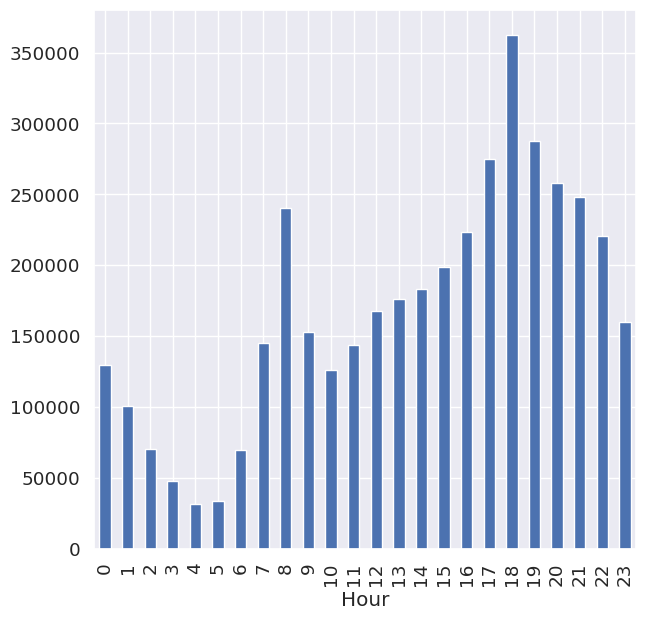

In [ ]:
dfTrainNEW.groupby('Hour')['y'].sum().plot(kind='bar');

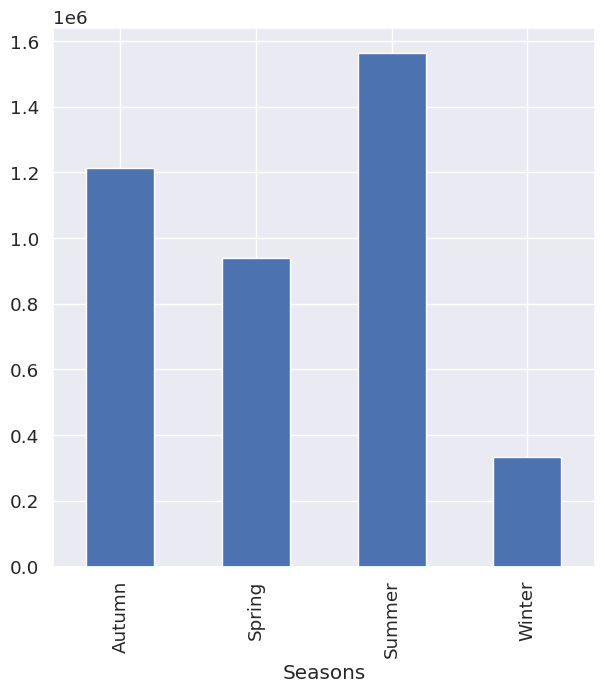

In [ ]:
dfTrainNEW.groupby('Seasons')['y'].sum().plot(kind='bar');

_________________________________________________

_______________________________________________________

# Check for skewness

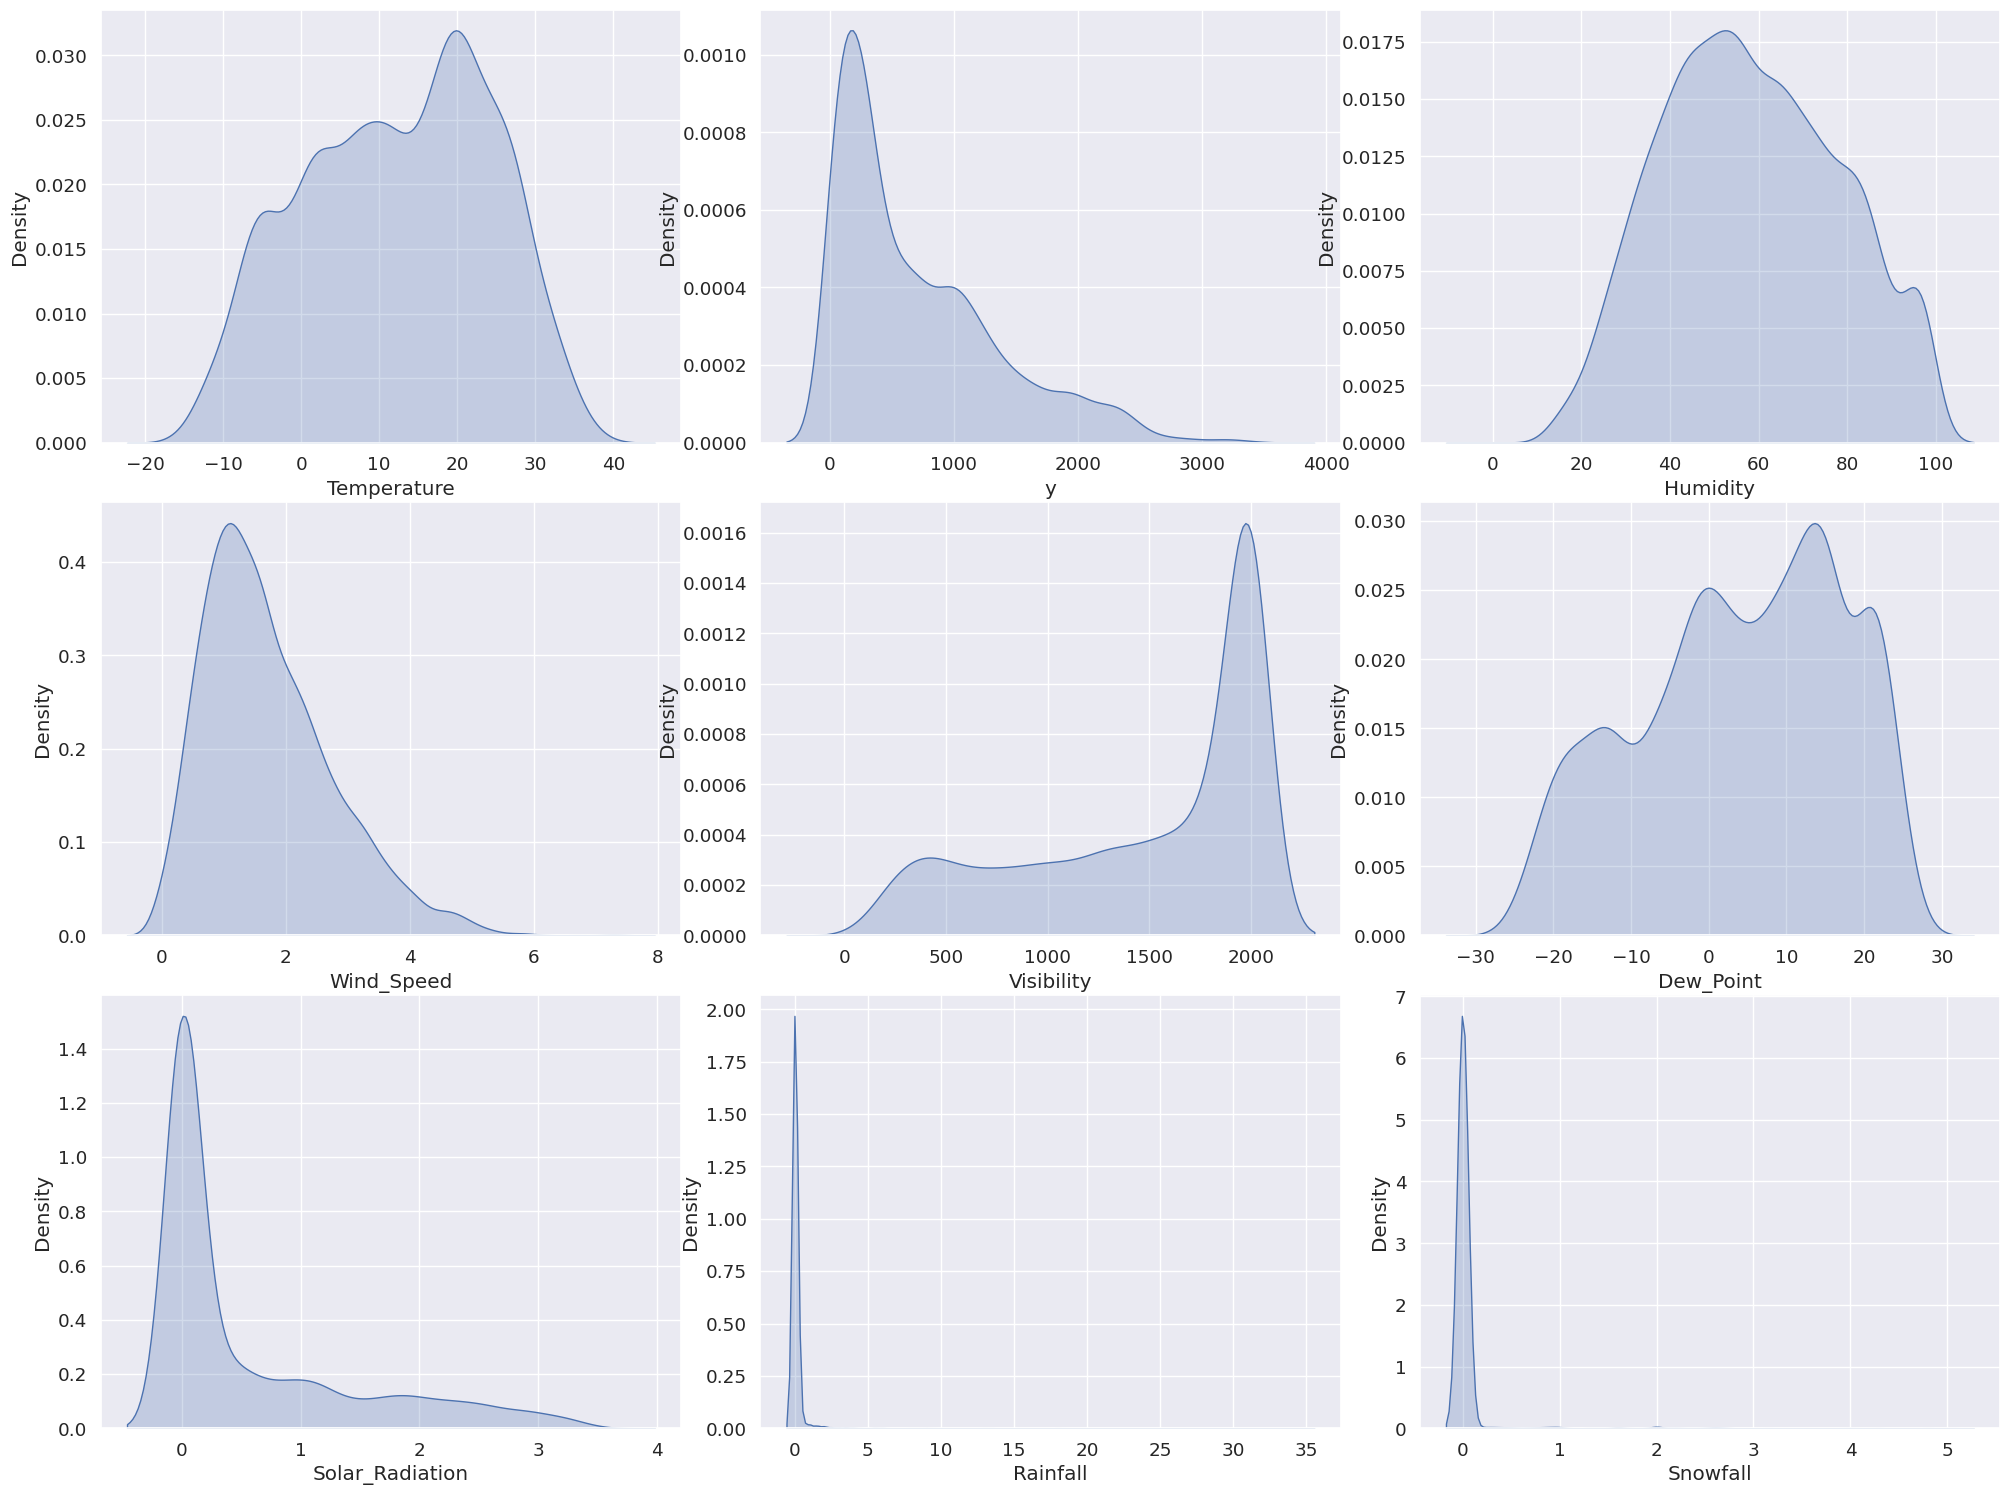

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(20,15)
figure.tight_layout()
sns.kdeplot(dfTrainNEW['Temperature']    ,shade=True, ax=axes[0][0]);
sns.kdeplot(dfTrainNEW['y']              ,shade=True, ax=axes[0][1]);
sns.kdeplot(dfTrainNEW['Humidity']       ,shade=True, ax=axes[0][2]);
sns.kdeplot(dfTrainNEW['Wind_Speed']     ,shade=True, ax=axes[1][0]);
sns.kdeplot(dfTrainNEW['Visibility']     ,shade=True, ax=axes[1][1]);
sns.kdeplot(dfTrainNEW['Dew_Point']      ,shade=True, ax=axes[1][2]);
sns.kdeplot(dfTrainNEW['Solar_Radiation'],shade=True, ax=axes[2][0]);
sns.kdeplot(dfTrainNEW['Rainfall']       ,shade=True, ax=axes[2][1]);
sns.kdeplot(dfTrainNEW['Snowfall']       ,shade=True, ax=axes[2][2]);

## Features to Check: `y`, `Wind_Speed`,`Visibility`,`Solar_Radiation`,`Rainfall`,`Snowfall`

In [ ]:
def SkewnessCheck(df,feature):
    df['log'+feature]   =df[feature].apply(np.log1p)
    df['sqrt'+feature]  =df[feature].apply(np.sqrt)
    df['squar'+feature] =np.power(df[feature],2)
    figure, axes = plt.subplots(nrows=1, ncols=4)
    figure.set_size_inches(20,10)
    sns.kdeplot(df['y']              ,shade=True, ax=axes[0]);
    sns.kdeplot(df['log'+feature]    ,shade=True, ax=axes[1]);
    sns.kdeplot(df['sqrt'+feature]   ,shade=True, ax=axes[2]);
    sns.kdeplot(df['squar'+feature]  ,shade=True, ax=axes[3]);

### `y`

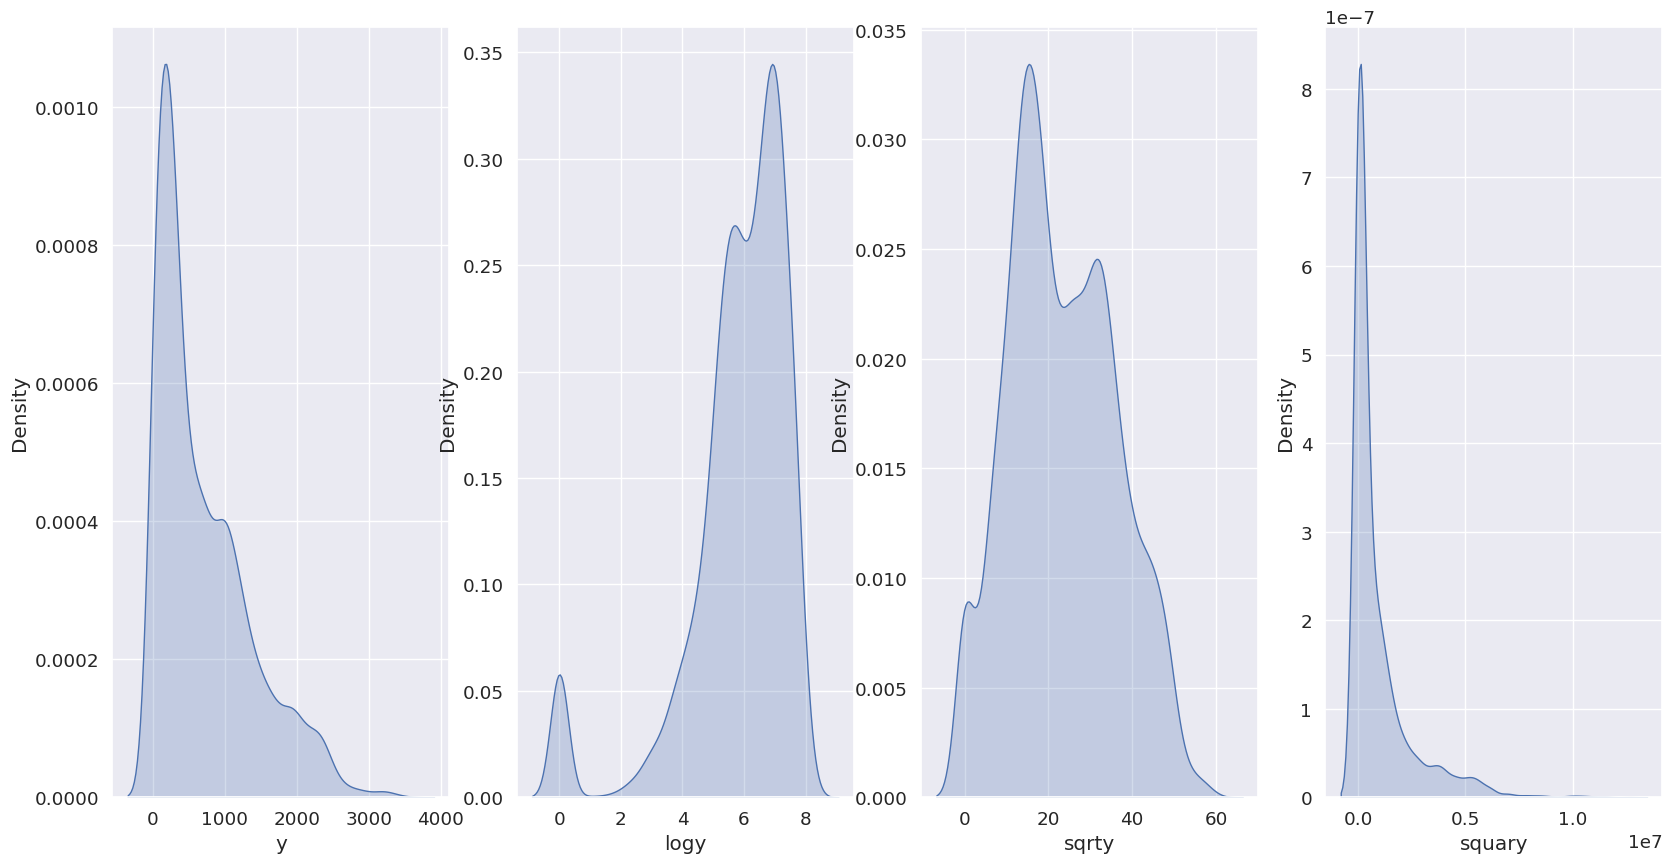

In [ ]:
SkewnessCheck(dfTrainNEW,'y')

### `Wind_Speed`

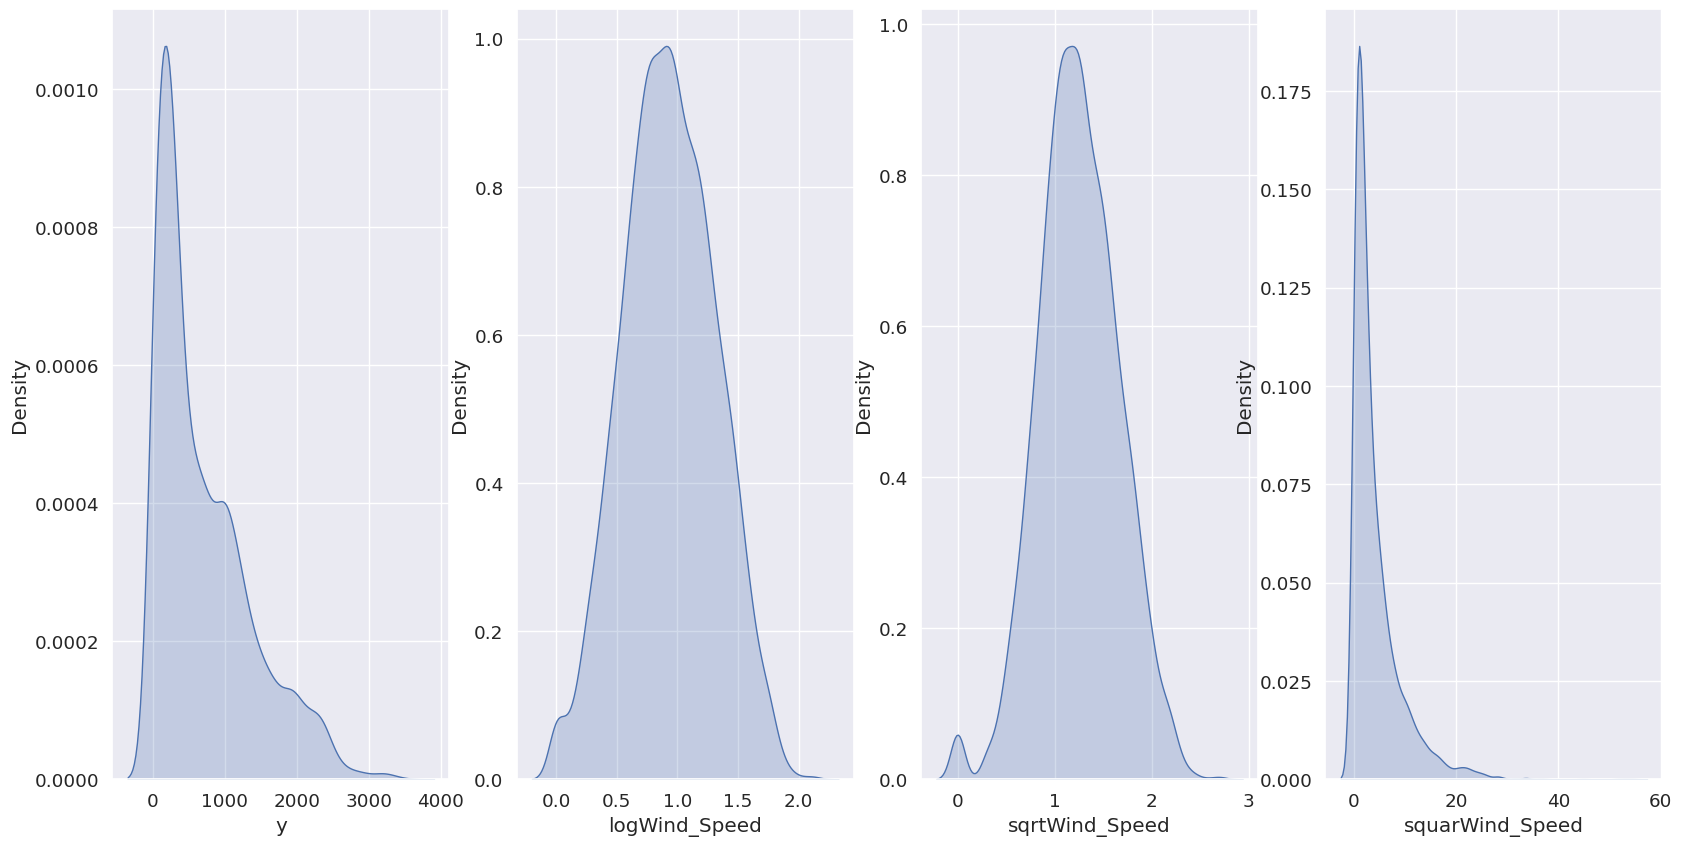

In [ ]:
SkewnessCheck(dfTrainNEW,'Wind_Speed')

### `Visibility`

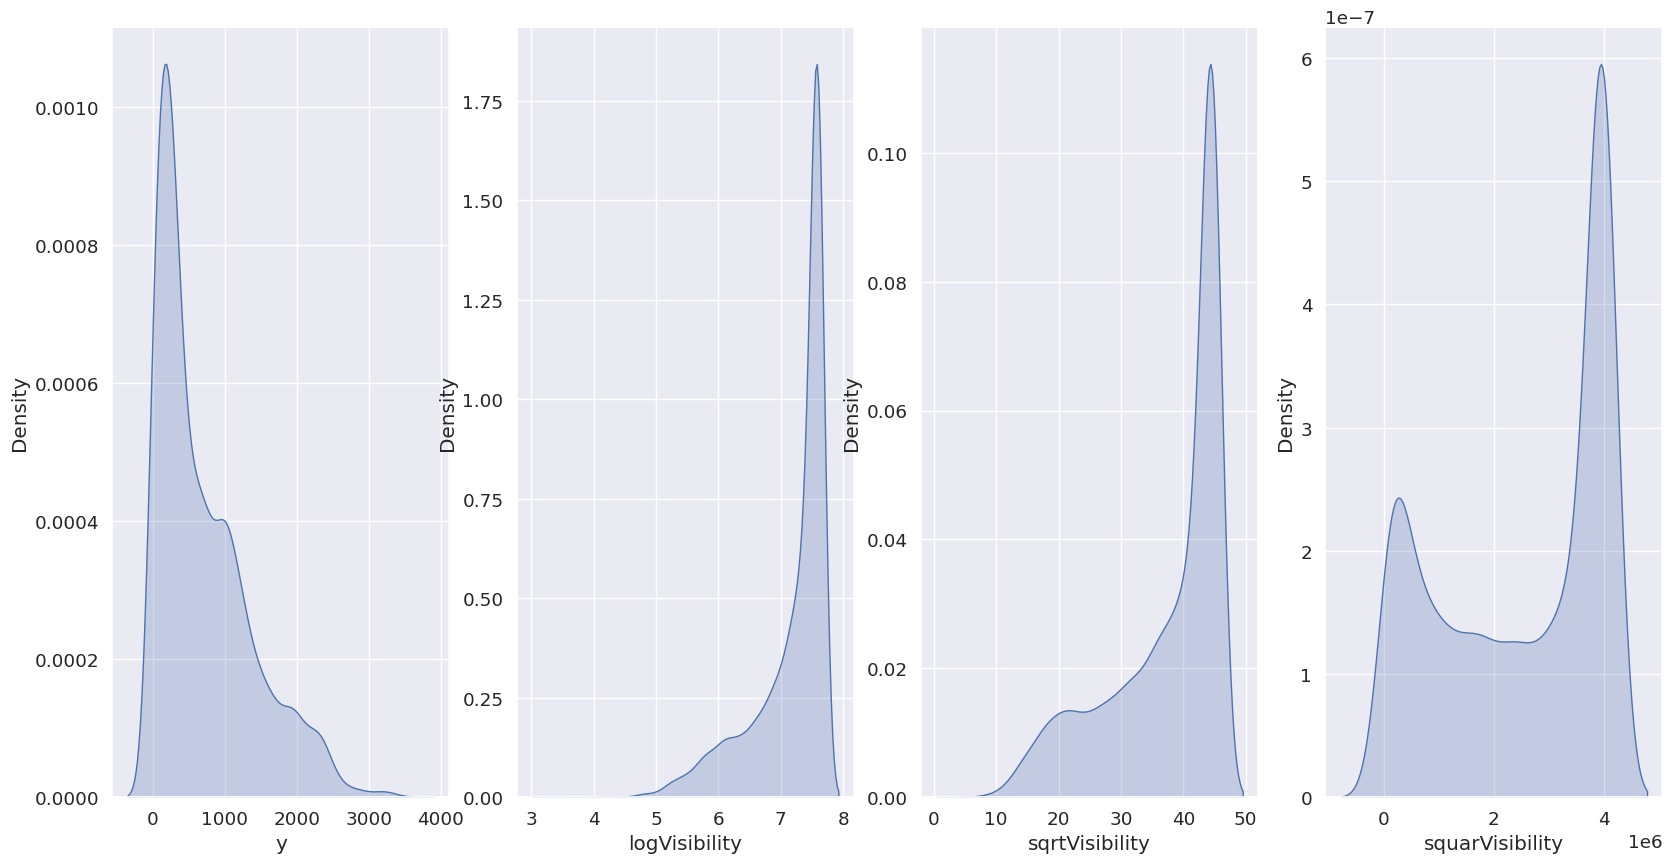

In [ ]:
SkewnessCheck(dfTrainNEW,'Visibility')

### `Solar_Radiation`

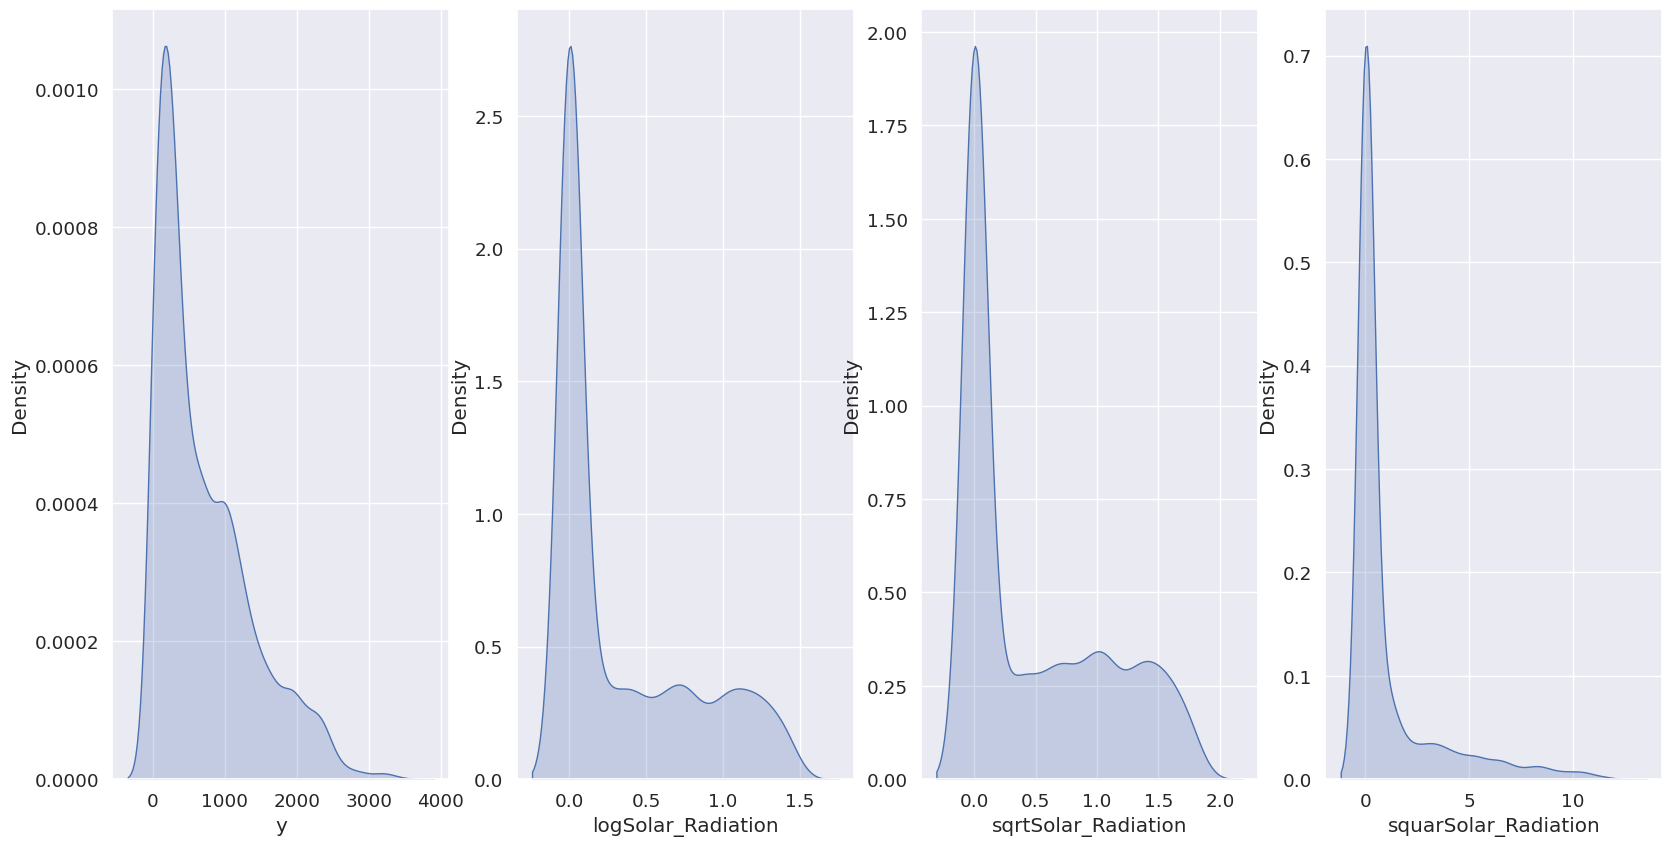

In [ ]:
SkewnessCheck(dfTrainNEW,'Solar_Radiation')

### `Rainfall`

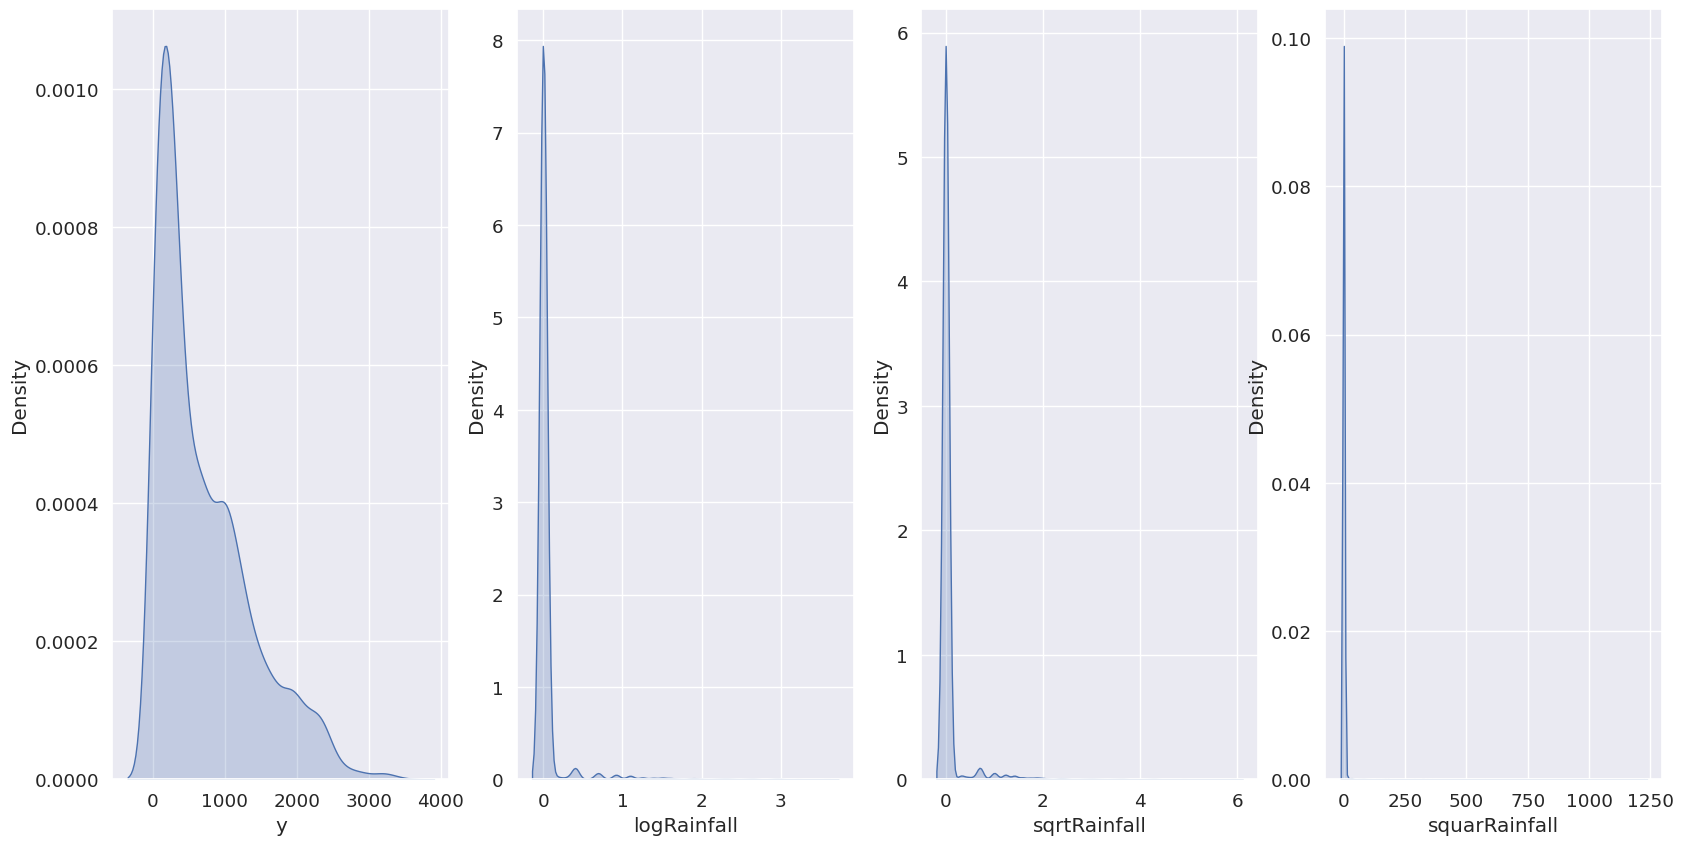

In [ ]:
SkewnessCheck(dfTrainNEW,'Rainfall')

### `Snowfall`

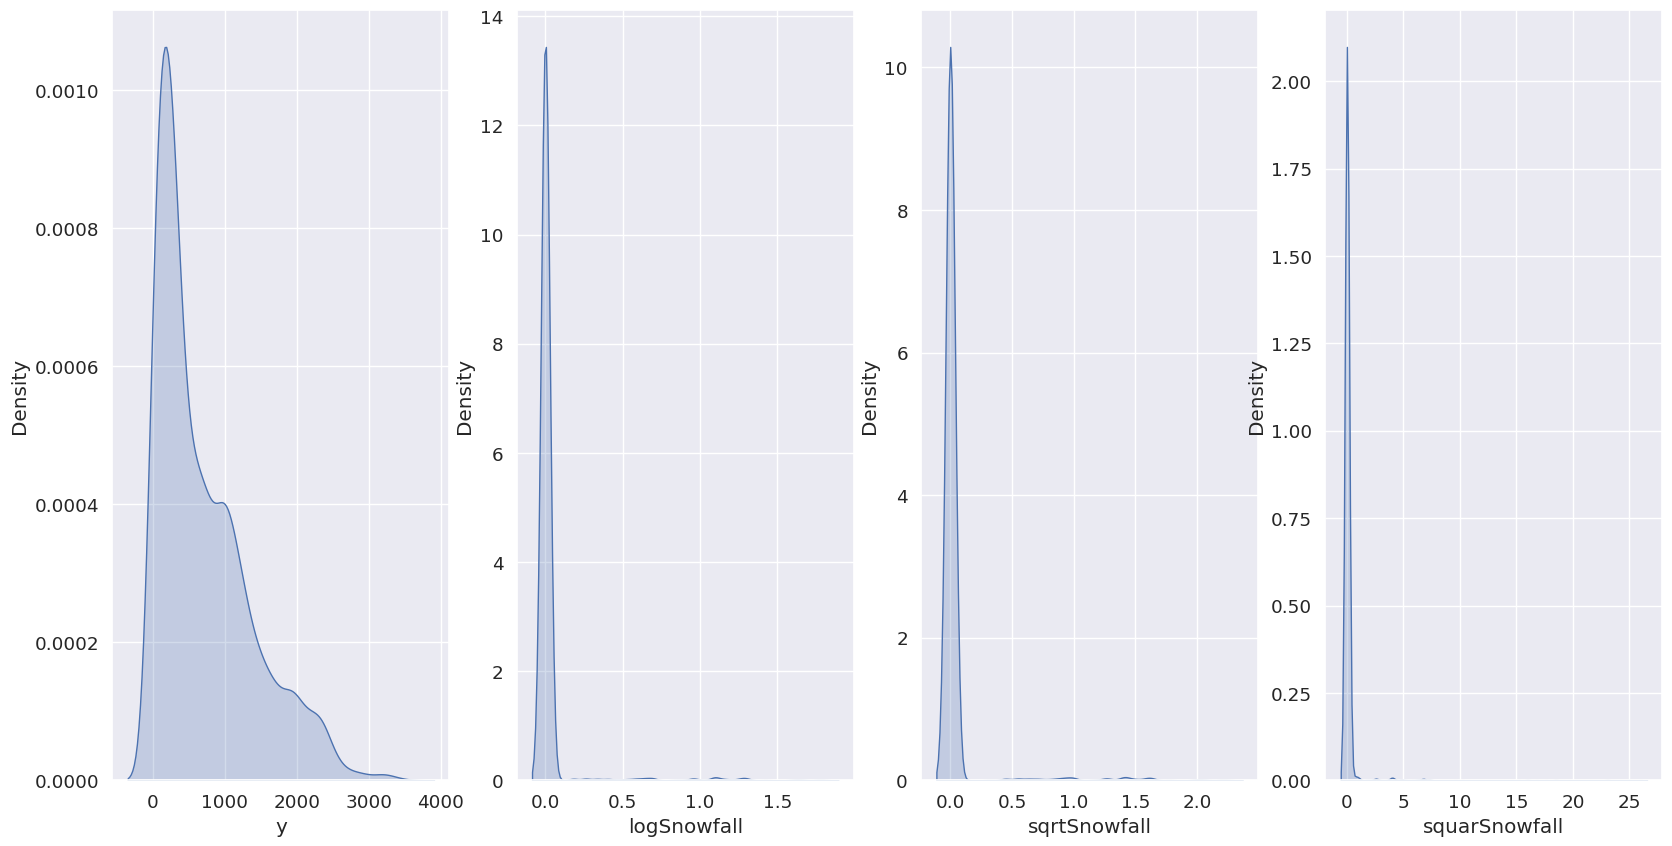

In [ ]:
SkewnessCheck(dfTrainNEW,'Snowfall')

### `SquareRoot` Y        ------> Best
### `Log` WindSpeed       ------> Best
### `Square` Visibility   ------> Best
### `SolarRadiation`?? Original or SquareRoot

## Do The Same To Test Data

In [ ]:
dfTestNEW['logWind_Speed']         =dfTestNEW['Wind_Speed'].apply(np.log1p)
dfTestNEW['sqrtWind_Speed']        =dfTestNEW['Wind_Speed'].apply(np.sqrt)
dfTestNEW['squarWind_Speed']       =np.power(dfTestNEW['Wind_Speed'],2)
dfTestNEW['logVisibility']         =dfTestNEW['Visibility'].apply(np.log1p)
dfTestNEW['sqrtVisibility']        =dfTestNEW['Visibility'].apply(np.sqrt)
dfTestNEW['squarVisibility']       =np.power(dfTestNEW['Visibility'],2)
dfTestNEW['logSolar_Radiation']    =dfTestNEW['Solar_Radiation'].apply(np.log1p)
dfTestNEW['sqrtSolar_Radiation']   =dfTestNEW['Solar_Radiation'].apply(np.sqrt)
dfTestNEW['squarSolar_Radiation']  =np.power(dfTestNEW['Solar_Radiation'],2)
dfTestNEW['logRainfall']           =dfTestNEW['Rainfall'].apply(np.log1p)
dfTestNEW['sqrtRainfall']          =dfTestNEW['Rainfall'].apply(np.sqrt)
dfTestNEW['squarRainfall']         =np.power(dfTestNEW['Rainfall'],2)
dfTestNEW['logSnowfall']           =dfTestNEW['Snowfall'].apply(np.log1p)
dfTestNEW['sqrtSnowfall']          =dfTestNEW['Snowfall'].apply(np.sqrt)
dfTestNEW['squarSnowfall']         =np.power(dfTestNEW['Snowfall'],2)

## Drop the Columns we Don't Need

In [ ]:
dfTrainNEW.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity', 'Wind_Speed',
       'Visibility', 'Dew_Point', 'Solar_Radiation', 'Rainfall', 'Snowfall',
       'Seasons', 'Holiday', 'Functioning_Day', 'Year', 'Month', 'Day',
       'DayName', 'DayNumber', 'WorkingDay', 'Day_Period', 'Rush_Hour',
       'Hour_Sin', 'Hour_Cos', 'DayNumber_Sin', 'DayNumber_Cos', 'Month_Sin',
       'Month_Cos', 'logy', 'sqrty', 'squary', 'logWind_Speed',
       'sqrtWind_Speed', 'squarWind_Speed', 'logVisibility', 'sqrtVisibility',
       'squarVisibility', 'logSolar_Radiation', 'sqrtSolar_Radiation',
       'squarSolar_Radiation', 'logRainfall', 'sqrtRainfall', 'squarRainfall',
       'logSnowfall', 'sqrtSnowfall', 'squarSnowfall'],
      dtype='object')

In [ ]:
dfTrainNEW.drop(columns=['logy','sqrty','squary','sqrtWind_Speed','squarWind_Speed','squarVisibility',
                         'sqrtVisibility', 'logVisibility', 'logSolar_Radiation', 'sqrtSolar_Radiation',
                         'squarSolar_Radiation','logRainfall', 'sqrtRainfall', 'squarRainfall', 'logSnowfall',
                         'sqrtSnowfall','squarSnowfall'],inplace=True)

In [ ]:
dfTrainNEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               5760 non-null   int64         
 1   Date             5760 non-null   datetime64[ns]
 2   y                5760 non-null   int64         
 3   Hour             5760 non-null   int64         
 4   Temperature      5760 non-null   int64         
 5   Humidity         5760 non-null   int64         
 6   Wind_Speed       5760 non-null   float64       
 7   Visibility       5760 non-null   int64         
 8   Dew_Point        5760 non-null   float64       
 9   Solar_Radiation  5760 non-null   float64       
 10  Rainfall         5760 non-null   float64       
 11  Snowfall         5760 non-null   float64       
 12  Seasons          5760 non-null   object        
 13  Holiday          5760 non-null   int64         
 14  Functioning_Day  5760 non-null   int64  

In [ ]:
dfTestNEW.drop(columns=['sqrtWind_Speed','squarWind_Speed','squarVisibility', 'sqrtVisibility',
                        'logVisibility', 'logSolar_Radiation', 'sqrtSolar_Radiation', 'squarSolar_Radiation',
                        'logRainfall', 'sqrtRainfall', 'squarRainfall', 'logSnowfall', 'sqrtSnowfall',
                        'squarSnowfall'],inplace=True)

In [ ]:
dfTestNEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               3000 non-null   int64         
 1   Date             3000 non-null   datetime64[ns]
 2   Hour             3000 non-null   int64         
 3   Temperature      3000 non-null   int64         
 4   Humidity         3000 non-null   int64         
 5   Wind_Speed       3000 non-null   float64       
 6   Visibility       3000 non-null   int64         
 7   Dew_Point        3000 non-null   float64       
 8   Solar_Radiation  3000 non-null   float64       
 9   Rainfall         3000 non-null   float64       
 10  Snowfall         3000 non-null   float64       
 11  Seasons          3000 non-null   object        
 12  Holiday          3000 non-null   int64         
 13  Functioning_Day  3000 non-null   int64         
 14  Year             3000 non-null   int64  

________________________________________________

# Plots To Visualize the Data

## Case1

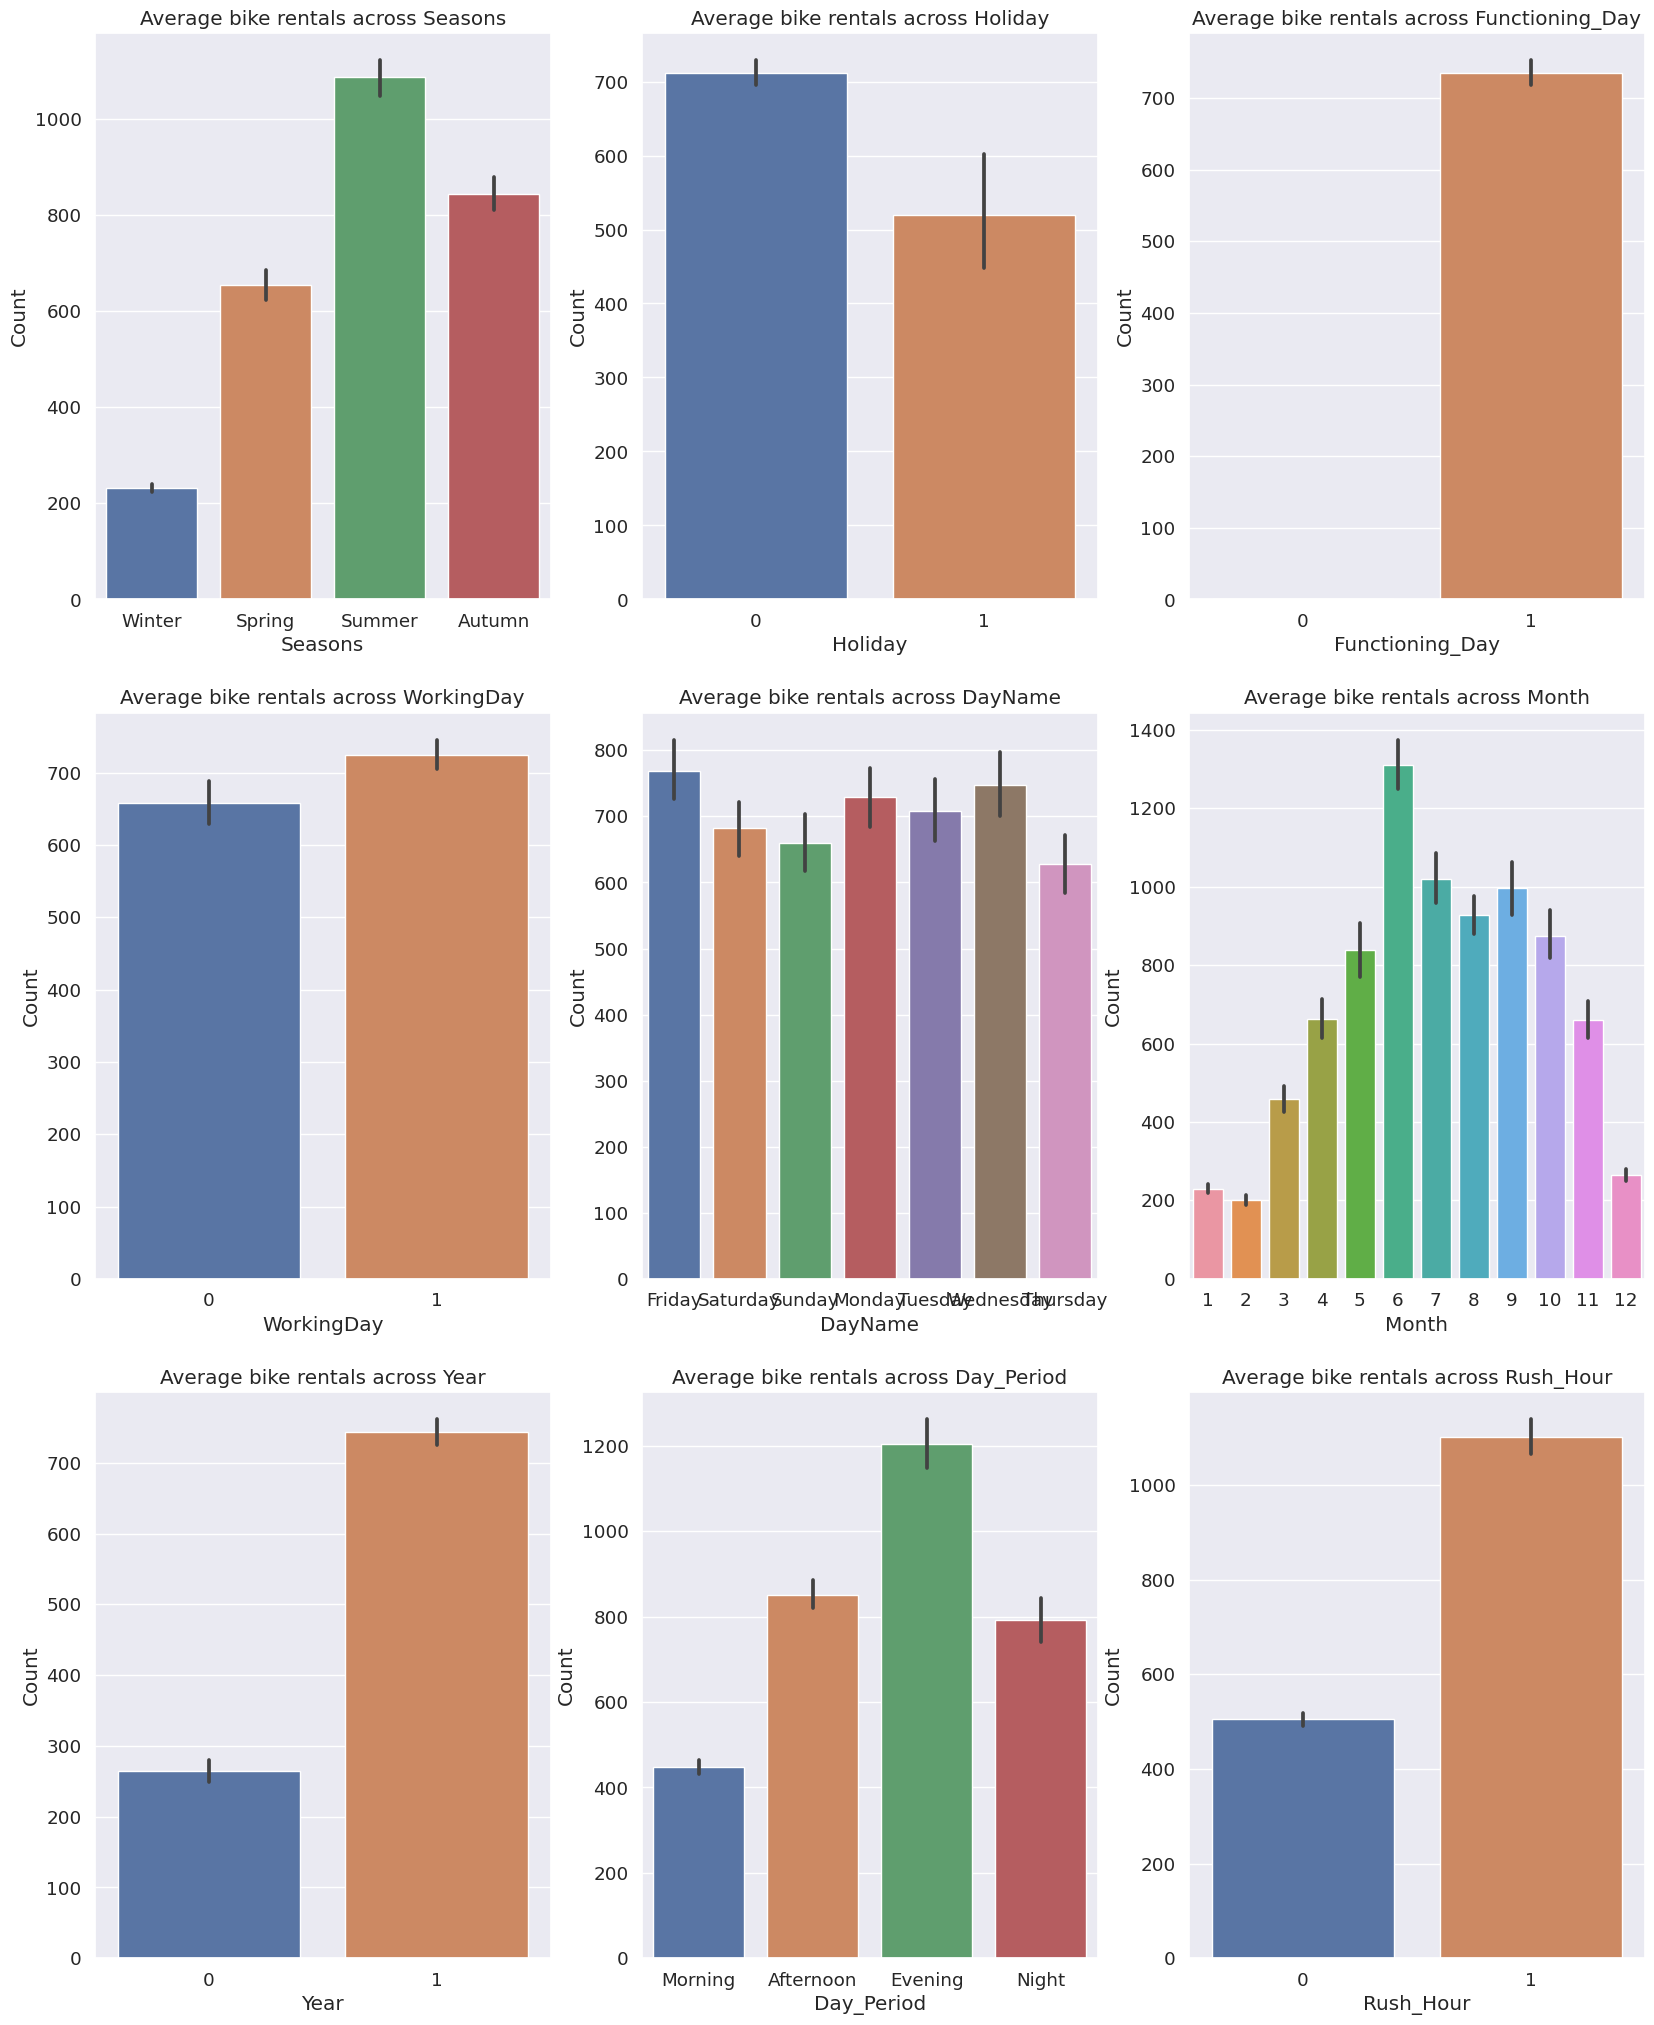

In [ ]:
FeatureList=['Seasons', 'Holiday', 'Functioning_Day', 'WorkingDay','DayName',
                 'Month','Year','Day_Period', 'Rush_Hour']
def BarPlot(df,FeatureList):
    fig = plt.figure(figsize=(20, 25))
    i=1
    for feature in FeatureList:
        axes = fig.add_subplot(3, 3, i)
        sns.barplot(data=df, x=feature, y='y', ax=axes)
        axes.set(xlabel=feature, ylabel='Count', title='Average bike rentals across '+feature)
        i+=1

BarPlot(dfTrainNEW,FeatureList)

## Case2

<Axes: xlabel='Day', ylabel='y'>

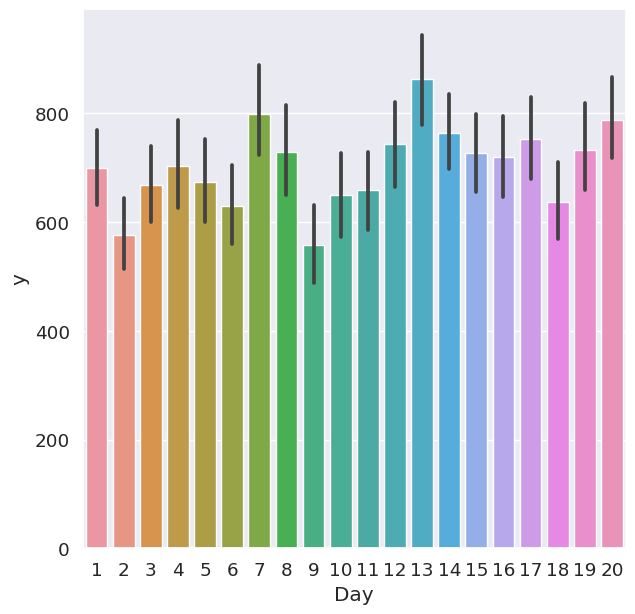

In [ ]:
sns.barplot(data=dfTrainNEW, x='Day', y='y')

## Case3

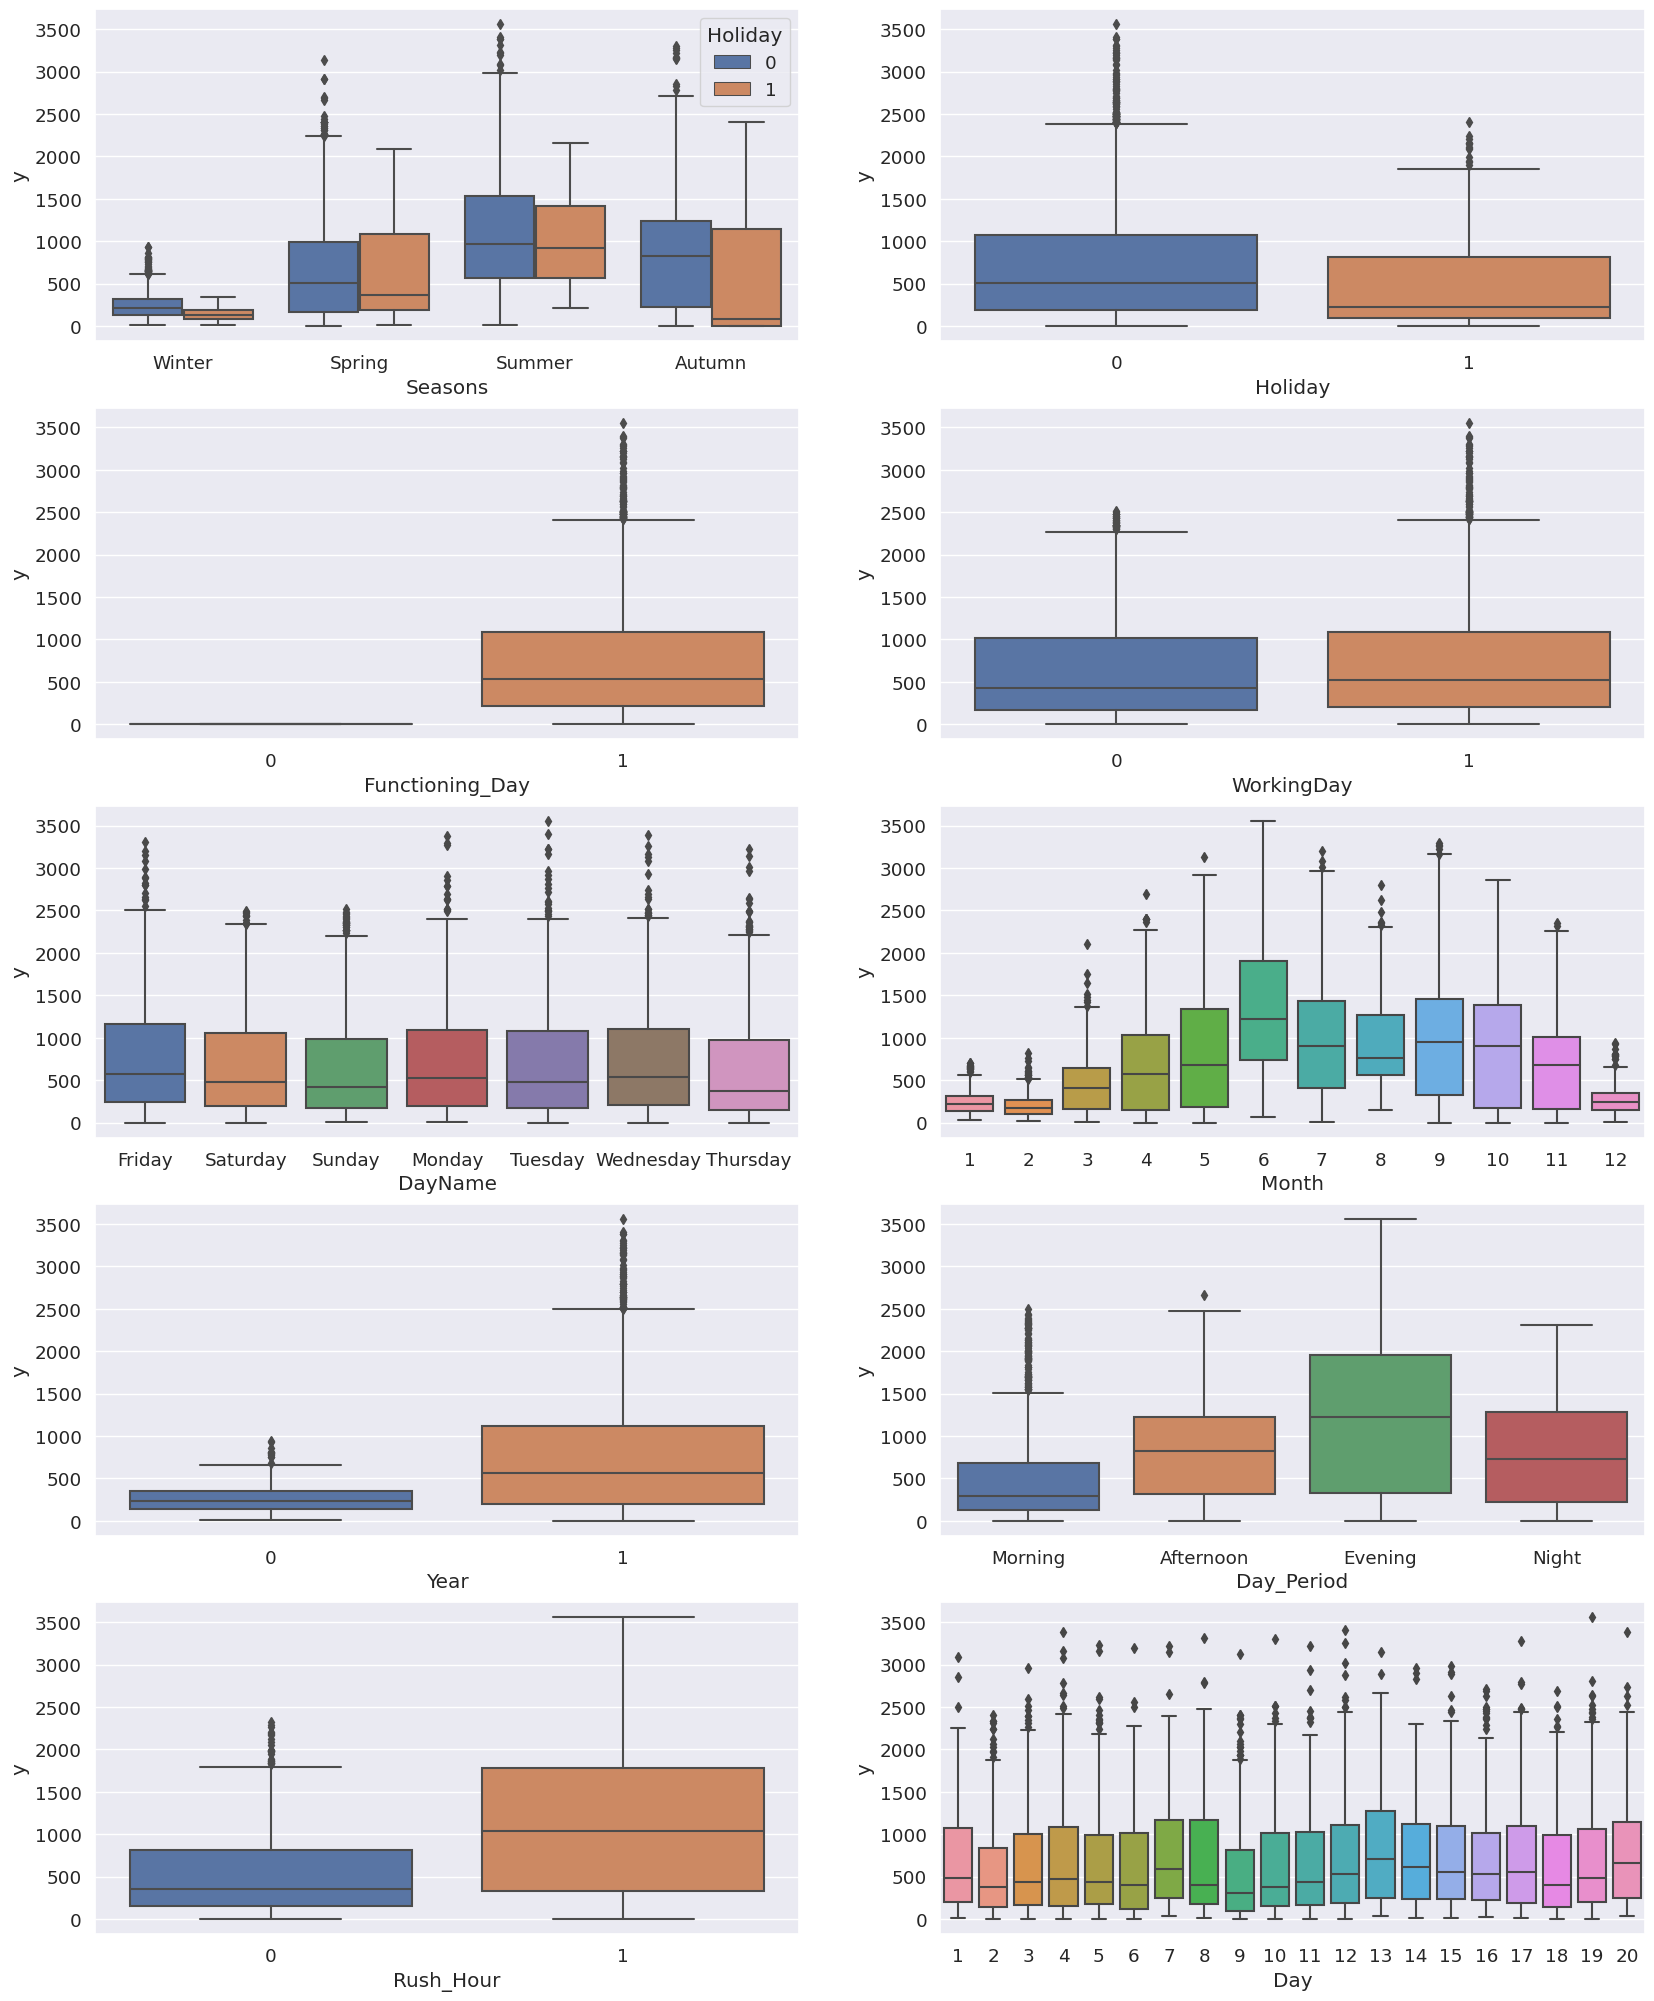

In [ ]:
f, axes = plt.subplots(5, 2, figsize=(20, 25))

sns.boxplot(data=dfTrainNEW, y='y', x='Seasons'        , ax=axes[0][0],hue='Holiday')
sns.boxplot(data=dfTrainNEW, y='y', x='Holiday'        , ax=axes[0][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Functioning_Day', ax=axes[1][0])
sns.boxplot(data=dfTrainNEW, y='y', x='WorkingDay'     , ax=axes[1][1])
sns.boxplot(data=dfTrainNEW, y='y', x='DayName'        , ax=axes[2][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Month'          , ax=axes[2][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Year'           , ax=axes[3][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Day_Period'     , ax=axes[3][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Rush_Hour'      , ax=axes[4][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Day'            , ax=axes[4][1])

plt.show()

## Case4

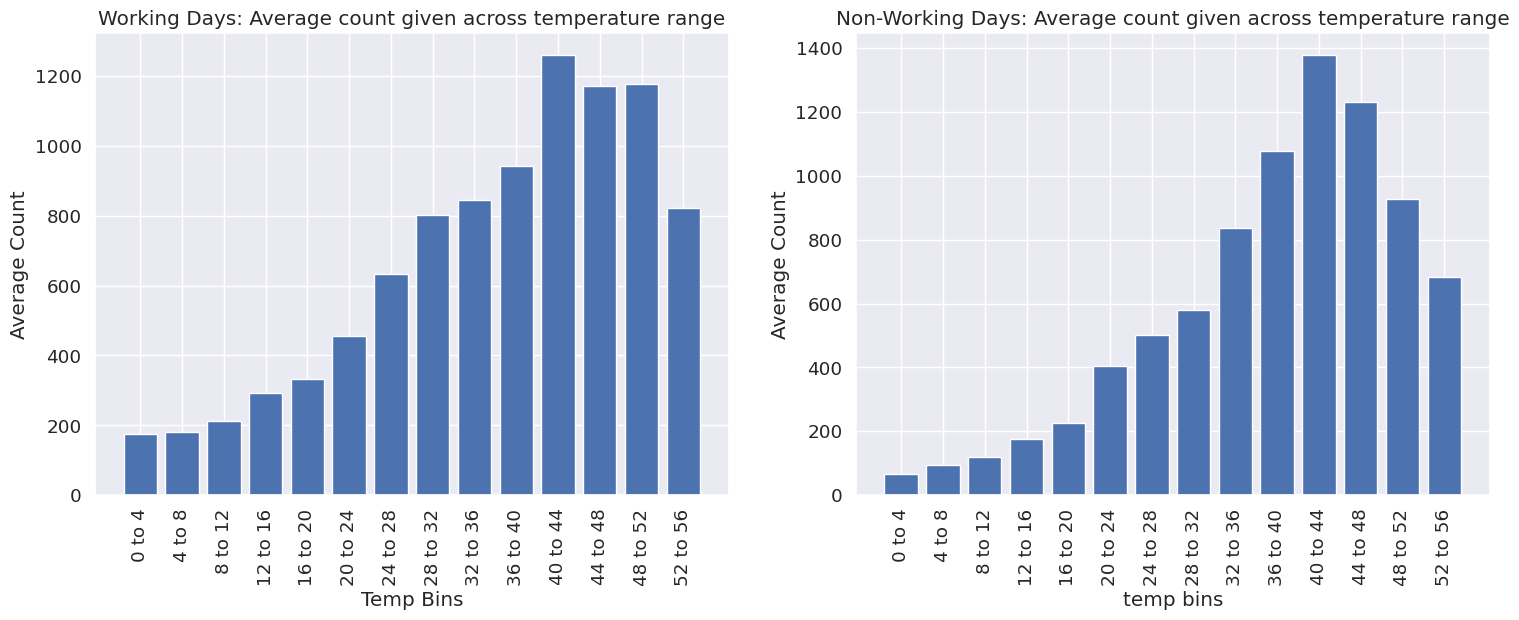

In [ ]:
dfTrainNEW_w = dfTrainNEW[dfTrainNEW["WorkingDay"] == 1]
dfTrainNEW_nw = dfTrainNEW[dfTrainNEW["WorkingDay"] == 0]

bin_size = 4
dfTrainNEW_w['Temp Round'] = dfTrainNEW_w['Temperature']//bin_size
dfTrainNEW_nw['Temp Round'] = dfTrainNEW_nw['Temperature']//bin_size

mean_count_vs_temp_w = dfTrainNEW_w.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nw.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average count given across temperature range')

plt.show()

## Case5

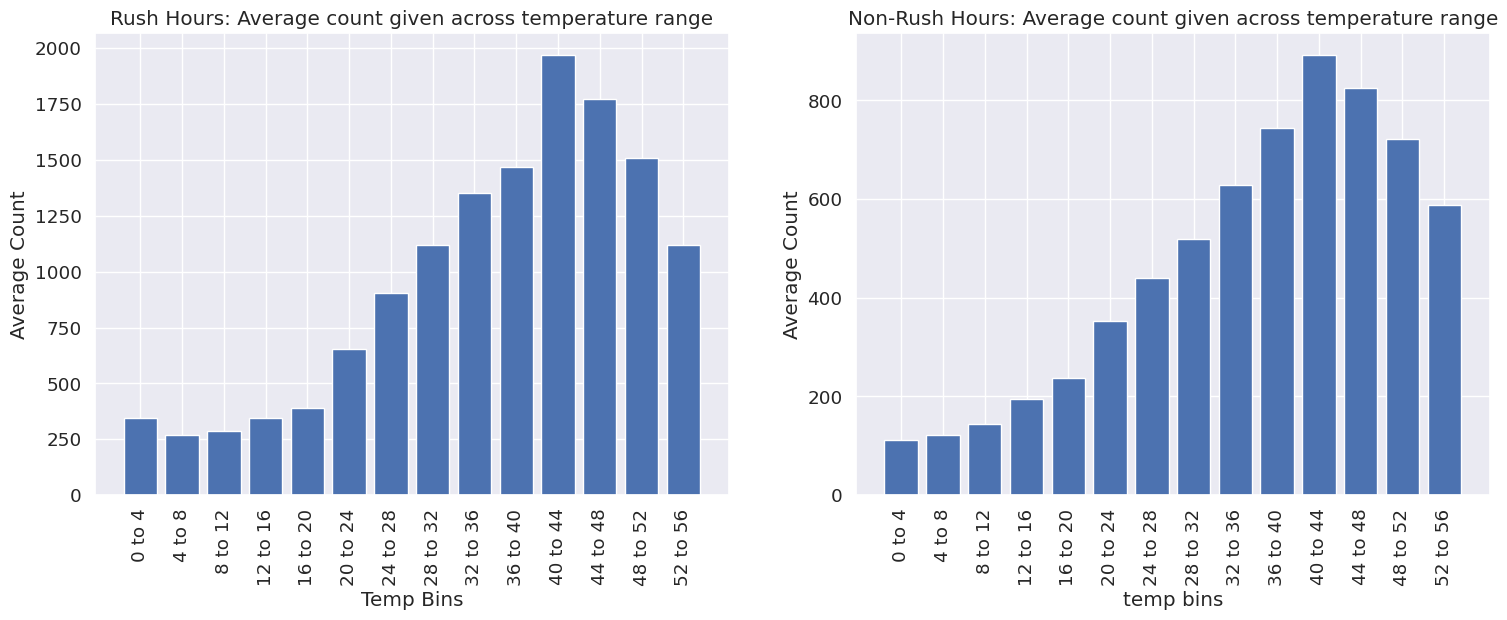

In [ ]:
dfTrainNEW_R = dfTrainNEW[dfTrainNEW["Rush_Hour"] == 1]
dfTrainNEW_nR = dfTrainNEW[dfTrainNEW["Rush_Hour"] == 0]

bin_size = 4
dfTrainNEW_R['Temp Round'] = dfTrainNEW_R['Temperature']//bin_size
dfTrainNEW_nR['Temp Round'] = dfTrainNEW_nR['Temperature']//bin_size

mean_count_vs_temp_w = dfTrainNEW_R.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nR.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Rush Hours: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Rush Hours: Average count given across temperature range')

plt.show()

## Case6

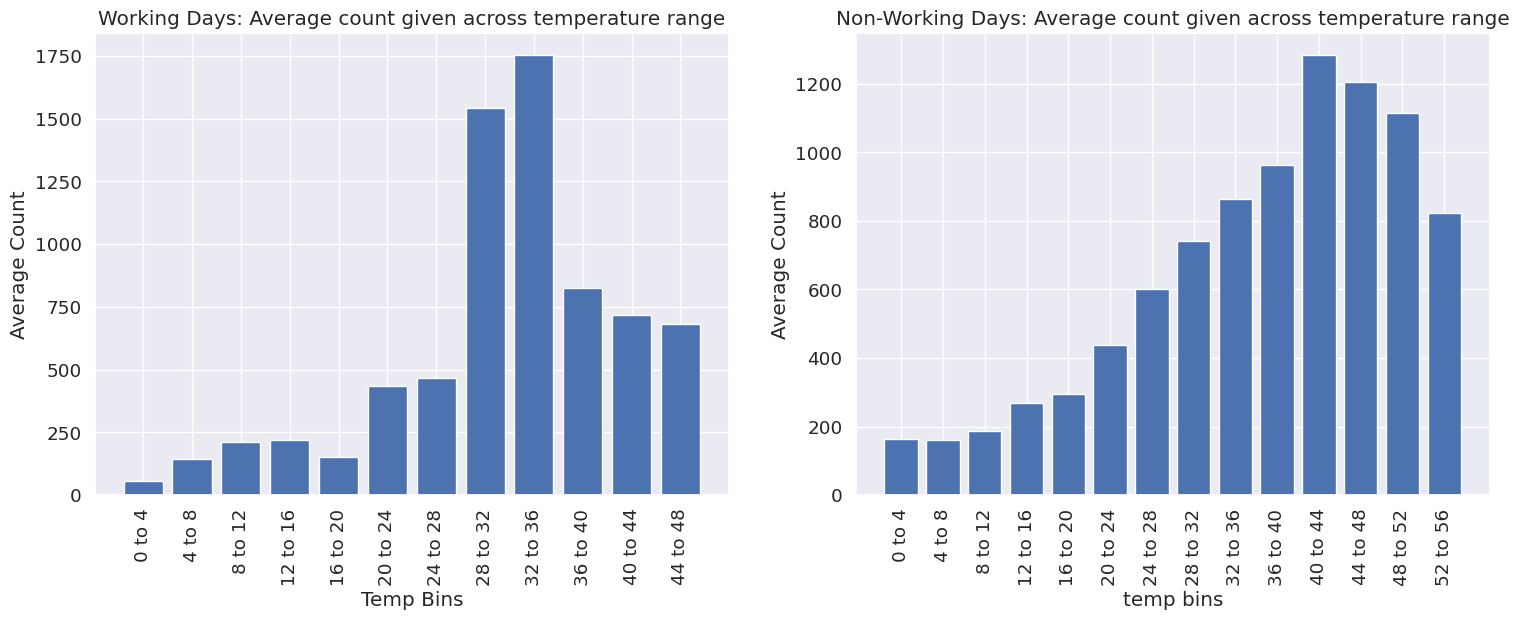

In [ ]:
dfTrainNEW_w  = dfTrainNEW[dfTrainNEW["Holiday"] == 1]
dfTrainNEW_nw = dfTrainNEW[dfTrainNEW["Holiday"] == 0]

bin_size = 4
dfTrainNEW_w['Temp Round']  = dfTrainNEW_w['Temperature']//bin_size
dfTrainNEW_nw['Temp Round'] = dfTrainNEW_nw['Temperature']//bin_size

mean_count_vs_temp_w  = dfTrainNEW_w.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nw.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig  = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average count given across temperature range')

plt.show()

## Case7

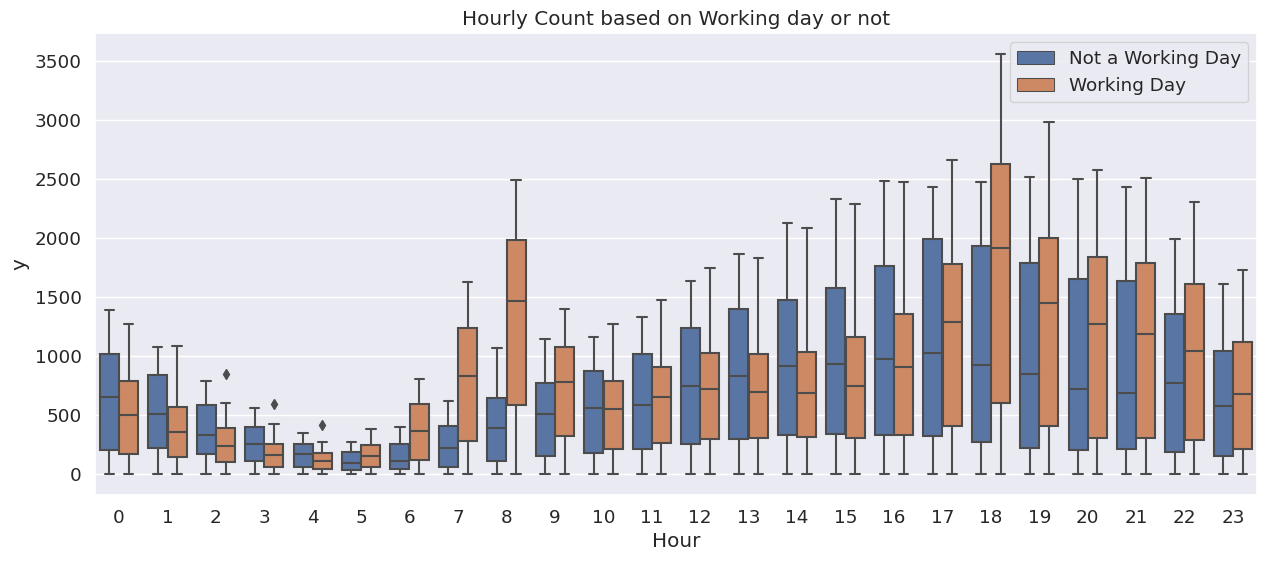

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=dfTrainNEW, y='y', x='Hour', hue='WorkingDay', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
axes.set(title='Hourly Count based on Working day or not')

plt.show()

## Case8

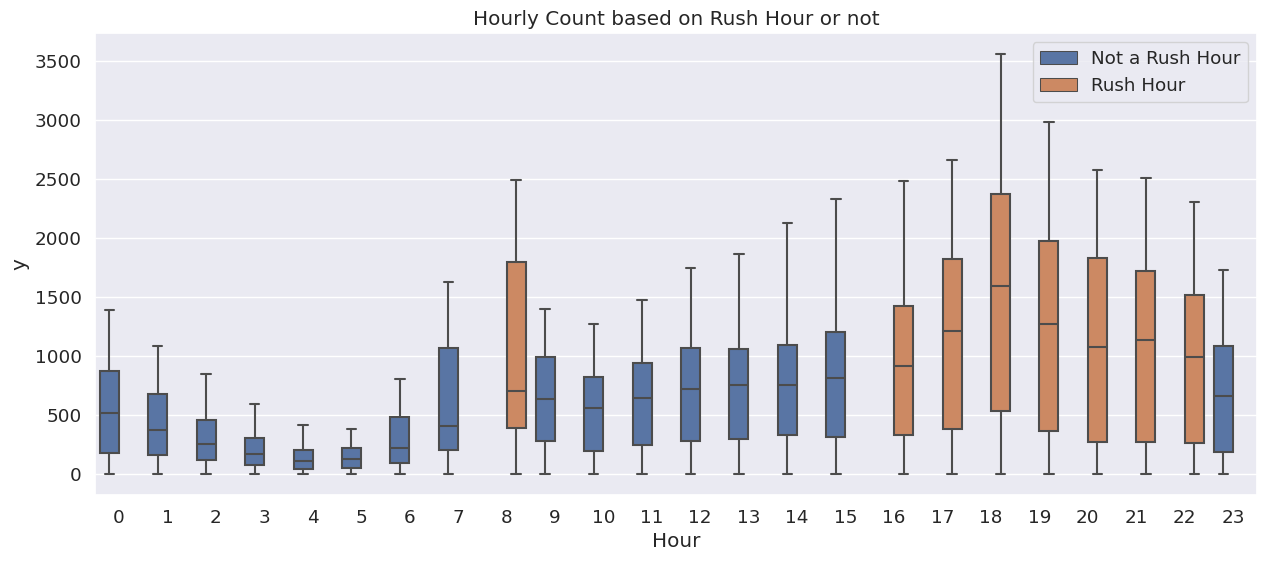

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=dfTrainNEW, y='y', x='Hour', hue='Rush_Hour', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Rush Hour', 'Rush Hour'])
axes.set(title='Hourly Count based on Rush Hour or not')

plt.show()

## Case9

TypeError: ignored

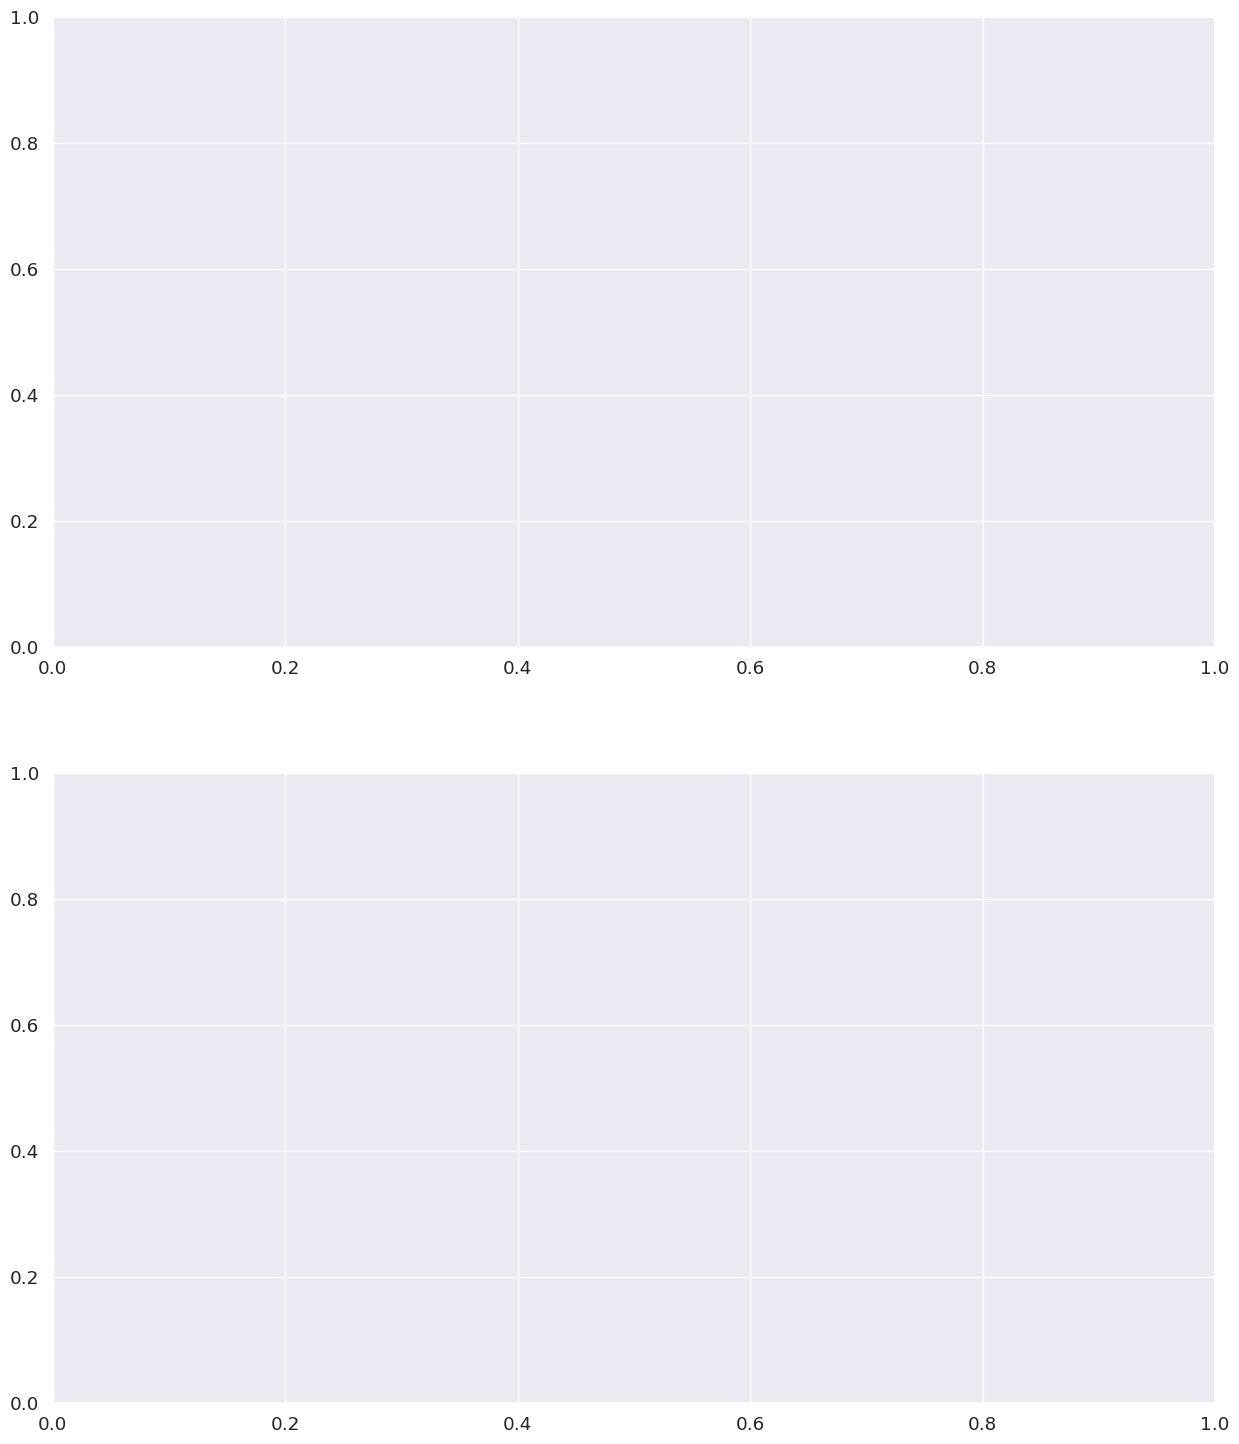

In [ ]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 18))
group_work_hour = pd.DataFrame(dfTrainNEW.groupby(['WorkingDay', 'Hour'])['y'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='Hour', y='y', hue='WorkingDay', ax=axes[0], legend=True)
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day if Working day or Not')

hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(dfTrainNEW.groupby(['DayName', 'Hour'])['y'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='Hour', y='y', hue='DayName', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Weekdays')

plt.show()

## Case10

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(dfTrainNEW.groupby(['Month', 'WorkingDay'])['y'].mean()).reset_index()
sns.barplot(data=group_month, x='Month', y='y', hue='WorkingDay', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

# Correlations

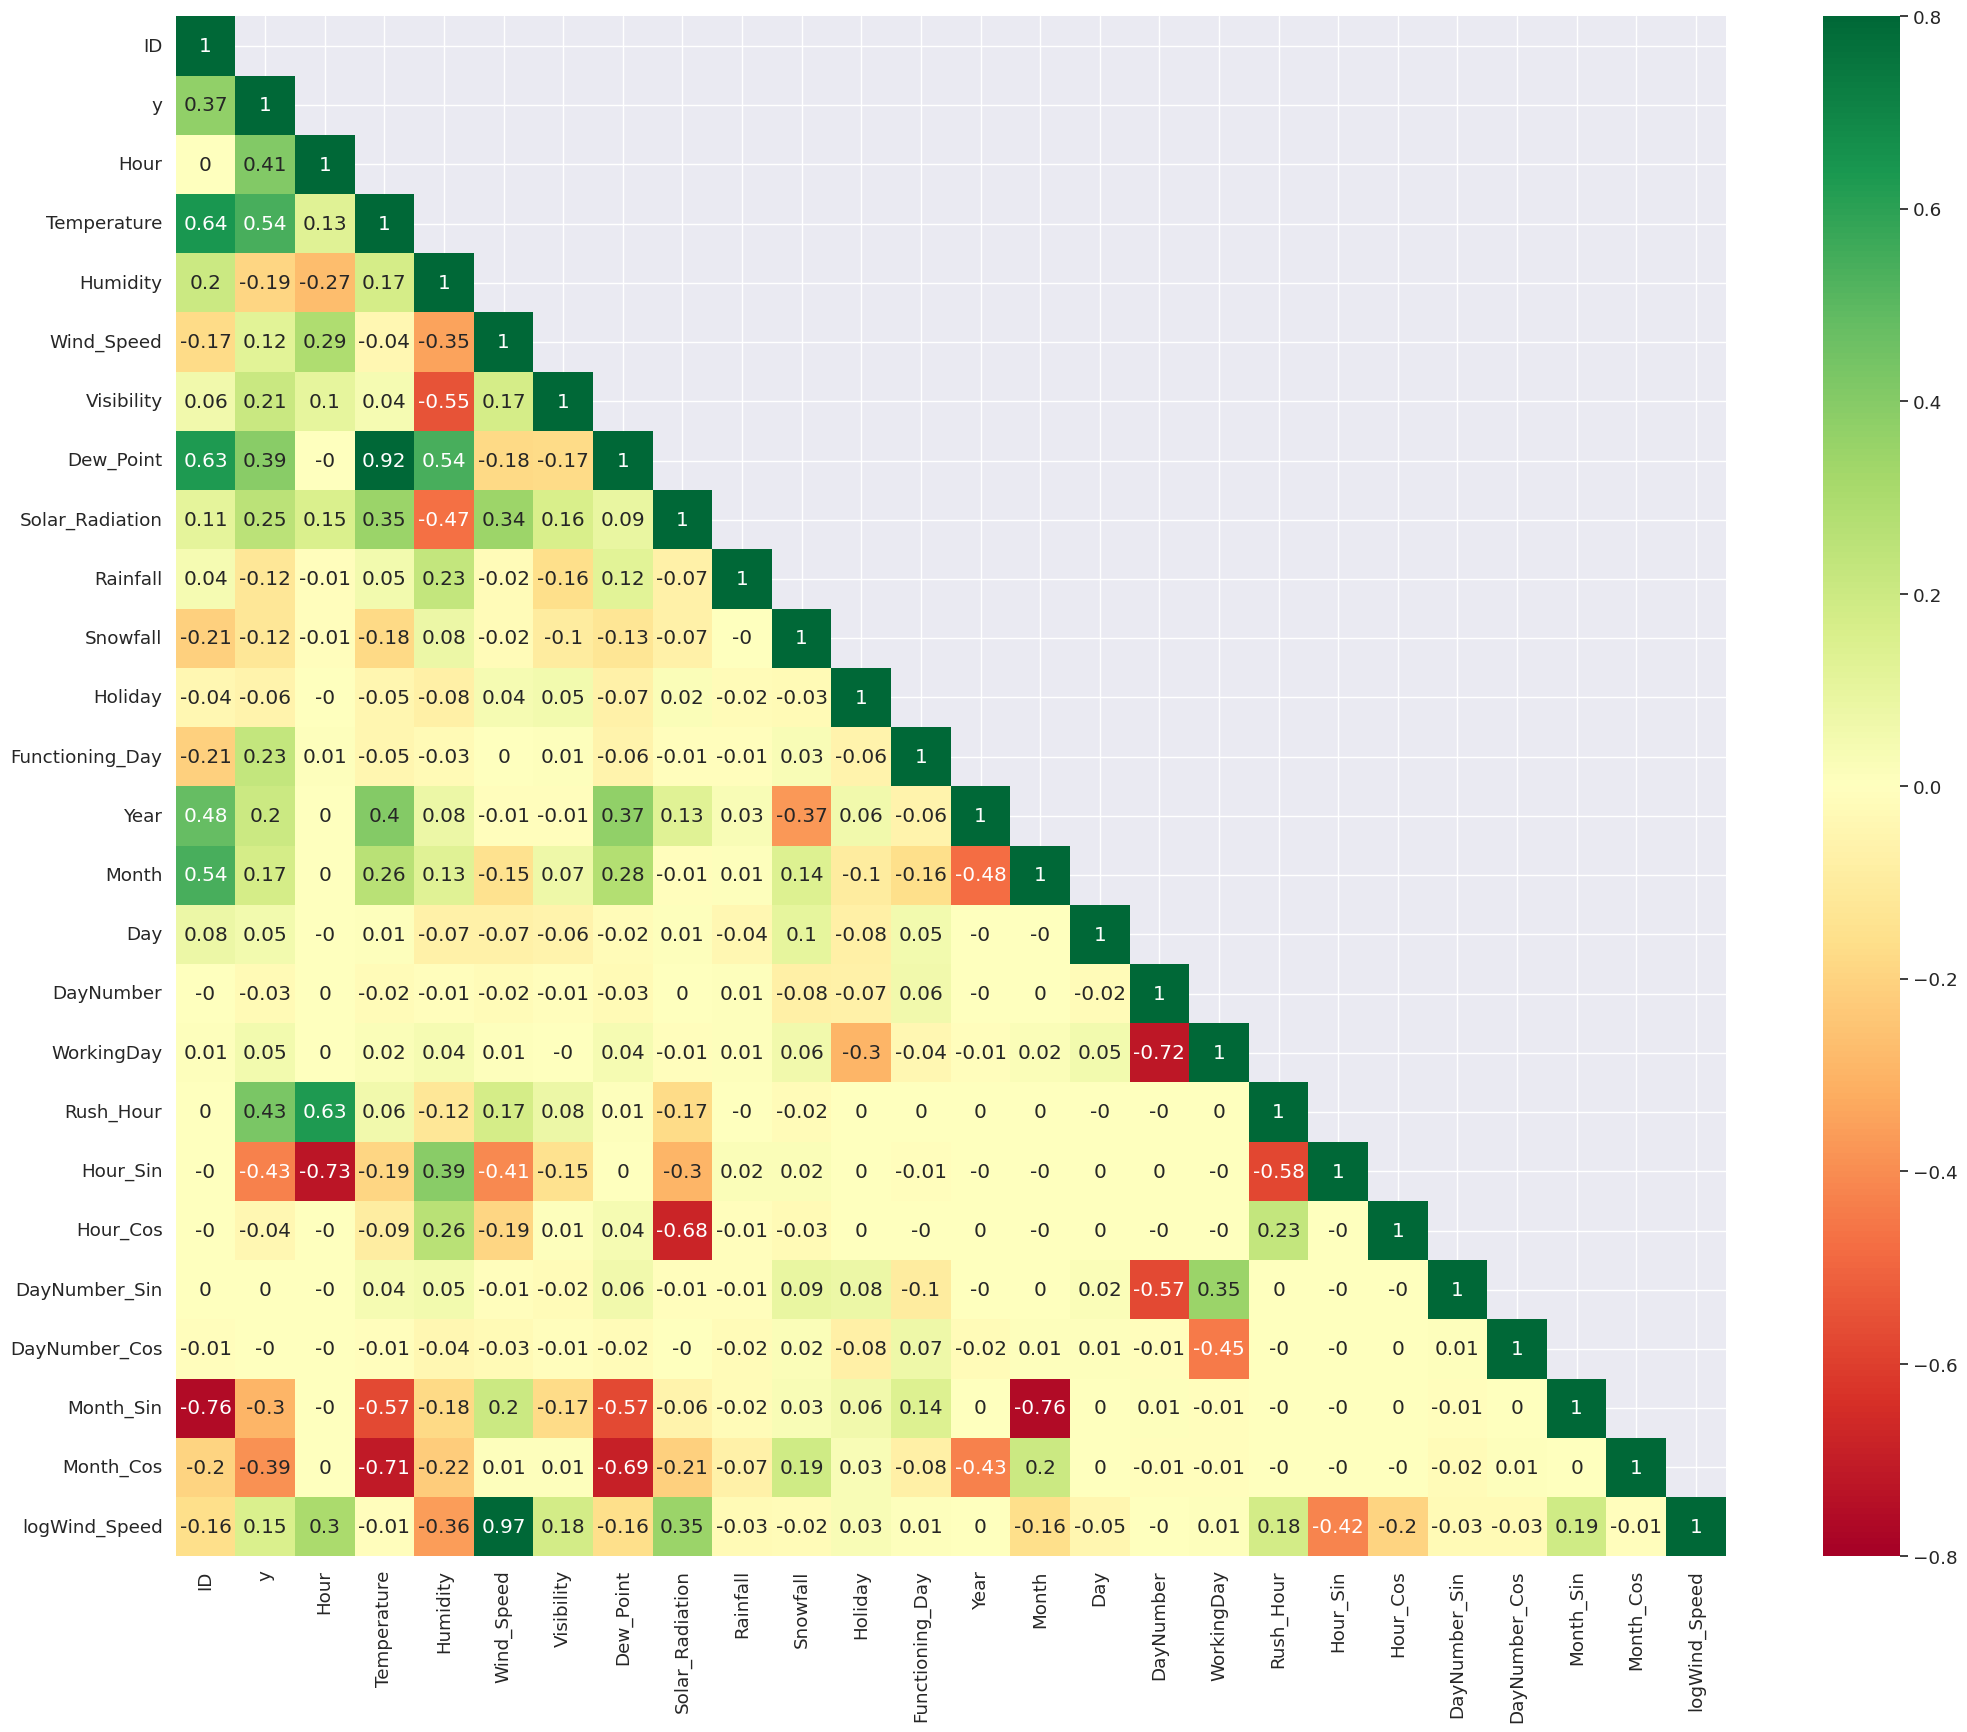

In [ ]:
corr_matrix = dfTrainNEW.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

fig = plt.figure(figsize=(25, 20))
sns.heatmap(np.round(corr_matrix,2), mask=mask, annot=True, cbar=True, vmax=0.8, vmin=-0.8, cmap='RdYlGn')
plt.show()

In [ ]:
abs(dfTrainNEW.corr()["y"]).sort_values(ascending=False)

y                  1.000000
Temperature        0.543863
Rush_Hour          0.429715
Hour_Sin           0.426541
Hour               0.407180
Dew_Point          0.392454
Month_Cos          0.385054
ID                 0.365359
Month_Sin          0.297890
Solar_Radiation    0.250601
Functioning_Day    0.227269
Visibility         0.214777
Year               0.201837
Humidity           0.191603
Month              0.167181
logWind_Speed      0.150271
Snowfall           0.120836
Rainfall           0.117711
Wind_Speed         0.116380
Holiday            0.058329
WorkingDay         0.047454
Day                0.045897
Hour_Cos           0.039578
DayNumber          0.025528
DayNumber_Cos      0.001677
DayNumber_Sin      0.000469
Name: y, dtype: float64

## Outliers Check

In [ ]:
def zscore(series):
    return (series-series.mean())/series.std()
dfTrainNEW_O=dfTrainNEW.copy()
dfTrainNEW_O['count_zscore'] = dfTrainNEW.groupby(['Hour', 'WorkingDay'])['y'].transform(zscore)
outlier_idx = np.abs(dfTrainNEW_O['count_zscore'])>3
outlier_data = dfTrainNEW_O.loc[outlier_idx, :]
print('Shape of the outlier data entries: ', outlier_data.shape)
outlier_data

Shape of the outlier data entries:  (7, 31)


,ID,Date,y,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Year,Month,Day,DayName,DayNumber,WorkingDay,Day_Period,Rush_Hour,Hour_Sin,Hour_Cos,DayNumber_Sin,DayNumber_Cos,Month_Sin,Month_Cos,logWind_Speed,count_zscore
2558,2558,2018-05-07,1970,14,24,42,1.2,1770,10.3,1.93,0.0,0.0,Spring,0,1,1,5,7,Monday,0,1,Afternoon,0,-0.631088,-0.775711,0.000000,1.0,5.000000e-01,-0.866025,0.788457,3.103850
2559,2559,2018-05-07,2191,15,24,38,2.1,1478,9.3,1.85,0.0,0.0,Spring,0,1,1,5,7,Monday,0,1,Afternoon,0,-0.816970,-0.576680,0.000000,1.0,5.000000e-01,-0.866025,1.131402,3.067372
3170,3170,2018-06-13,847,2,18,75,0.6,1986,13.8,0.00,0.0,0.0,Summer,0,1,1,6,13,Wednesday,2,1,Morning,0,0.519584,0.854419,0.866025,-0.5,1.224647e-16,-1.000000,0.470004,3.313559
3171,3171,2018-06-13,591,3,18,73,1.0,1951,13.5,0.00,0.0,0.0,Summer,0,1,1,6,13,Wednesday,2,1,Morning,0,0.730836,0.682553,0.866025,-0.5,1.224647e-16,-1.000000,0.693147,3.500005
3172,3172,2018-06-13,421,4,18,74,0.9,1933,13.9,0.00,0.0,0.0,Summer,0,1,1,6,13,Wednesday,2,1,Morning,0,0.887885,0.460065,0.866025,-0.5,1.224647e-16,-1.000000,0.641854,3.712278
3182,3182,2018-06-13,2088,14,26,50,2.4,1119,15.3,2.95,0.0,0.0,Summer,0,1,1,6,13,Wednesday,2,1,Afternoon,0,-0.631088,-0.775711,0.866025,-0.5,1.224647e-16,-1.000000,1.223775,3.388935
3183,3183,2018-06-13,2288,15,25,50,2.2,1025,14.3,0.47,0.0,0.0,Summer,0,1,1,6,13,Wednesday,2,1,Afternoon,0,-0.816970,-0.576680,0.866025,-0.5,1.224647e-16,-1.000000,1.163151,3.274106


##### Removing Outliers from Data

In [ ]:
#Removing outliers from Data
dfTrainNEW_Wo = dfTrainNEW_O.loc[~outlier_idx, :]
print('Shape of Data Before Outlier Pruning: ', dfTrainNEW.shape)
print('Shape of Data After Outlier Pruning: ', dfTrainNEW_Wo.shape)

Shape of Data Before Outlier Pruning:  (5760, 30)
Shape of Data After Outlier Pruning:  (5753, 31)


# Categorical Columns Encoding

## 1. One Hot Encoding

In [ ]:
def OneHotEncoding(df,FeaturesL,Train_or_Test):
    if Train_or_Test == 'Train':
        dfTrainEncoded_Dummies = df.copy()
        dfTrainEncoded_Dummies = pd.get_dummies(dfTrainEncoded_Dummies,columns=FeaturesL,drop_first=True)
        return dfTrainEncoded_Dummies
    elif Train_or_Test == 'Test':
        dfTestEncoded_Dummies  = df.copy()
        dfTestEncoded_Dummies  = pd.get_dummies(dfTestEncoded_Dummies, columns=FeaturesL,drop_first=True)
        return dfTestEncoded_Dummies

_______________________________

## 2. Label Encoding

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

def LabelEncoding(df,FeaturesL,Train_or_Test):
    if Train_or_Test == 'Train':
        dfTrainEncoded_Labels = df.copy()
        dfTrainEncoded_Labels = MultiColumnLabelEncoder(columns=FeaturesL).fit_transform(dfTrainEncoded_Labels)
        return dfTrainEncoded_Labels
    elif Train_or_Test == 'Test':
        dfTestEncoded_Labels = df.copy()
        dfTestEncoded_Labels = MultiColumnLabelEncoder(columns=FeaturesL).fit_transform(dfTestEncoded_Labels)
        return dfTestEncoded_Labels

________________

# Check the Correlation

## 1. One Hot Encoding

In [ ]:
FeaturesL=['DayName','Seasons','Day_Period']

In [ ]:
dfTrainEncoded_Dummies=OneHotEncoding(dfTrainNEW,FeaturesL,'Train')

In [ ]:
abs(dfTrainEncoded_Dummies.corr()["y"]).sort_values(ascending=False)

y                     1.000000
Temperature           0.543863
Rush_Hour             0.429715
Hour_Sin              0.426541
Seasons_Winter        0.415673
Hour                  0.407180
Dew_Point             0.392454
Day_Period_Morning    0.389117
Month_Cos             0.385054
ID                    0.365359
Day_Period_Evening    0.341755
Seasons_Summer        0.336811
Month_Sin             0.297890
Solar_Radiation       0.250601
Functioning_Day       0.227269
Visibility            0.214777
Year                  0.201837
Humidity              0.191603
Month                 0.167181
logWind_Speed         0.150271
Snowfall              0.120836
Rainfall              0.117711
Wind_Speed            0.116380
Holiday               0.058329
WorkingDay            0.047454
DayName_Thursday      0.047000
Day                   0.045897
Seasons_Spring        0.044513
Day_Period_Night      0.041221
Hour_Cos              0.039578
DayName_Sunday        0.027052
DayName_Wednesday     0.026911
DayNumbe

In [ ]:
abs(dfTrainEncoded_Dummies.corr()["y"]).sort_values().index

Index(['DayNumber_Sin', 'DayNumber_Cos', 'DayName_Tuesday', 'DayName_Saturday',
       'DayName_Monday', 'DayNumber', 'DayName_Wednesday', 'DayName_Sunday',
       'Hour_Cos', 'Day_Period_Night', 'Seasons_Spring', 'Day',
       'DayName_Thursday', 'WorkingDay', 'Holiday', 'Wind_Speed', 'Rainfall',
       'Snowfall', 'logWind_Speed', 'Month', 'Humidity', 'Year', 'Visibility',
       'Functioning_Day', 'Solar_Radiation', 'Month_Sin', 'Seasons_Summer',
       'Day_Period_Evening', 'ID', 'Month_Cos', 'Day_Period_Morning',
       'Dew_Point', 'Hour', 'Seasons_Winter', 'Hour_Sin', 'Rush_Hour',
       'Temperature', 'y'],
      dtype='object')

In [ ]:
dfTrainEncoded_Dummies.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity', 'Wind_Speed',
       'Visibility', 'Dew_Point', 'Solar_Radiation', 'Rainfall', 'Snowfall',
       'Holiday', 'Functioning_Day', 'Year', 'Month', 'Day', 'DayNumber',
       'WorkingDay', 'Rush_Hour', 'Hour_Sin', 'Hour_Cos', 'DayNumber_Sin',
       'DayNumber_Cos', 'Month_Sin', 'Month_Cos', 'logWind_Speed',
       'DayName_Monday', 'DayName_Saturday', 'DayName_Sunday',
       'DayName_Thursday', 'DayName_Tuesday', 'DayName_Wednesday',
       'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'Day_Period_Evening', 'Day_Period_Morning', 'Day_Period_Night'],
      dtype='object')

## 2. Label Encoding

In [ ]:
FeaturesL=['DayName','Seasons','Day_Period']

In [ ]:
dfTrainEncoded_Labels=LabelEncoding(dfTrainNEW,FeaturesL,'Train')

In [ ]:
abs(dfTrainEncoded_Labels.corr()["y"]).sort_values(ascending=False)

y                  1.000000
Temperature        0.543863
Rush_Hour          0.429715
Hour_Sin           0.426541
Hour               0.407180
Dew_Point          0.392454
Month_Cos          0.385054
ID                 0.365359
Month_Sin          0.297890
Solar_Radiation    0.250601
Seasons            0.239315
Day_Period         0.238598
Functioning_Day    0.227269
Visibility         0.214777
Year               0.201837
Humidity           0.191603
Month              0.167181
logWind_Speed      0.150271
Snowfall           0.120836
Rainfall           0.117711
Wind_Speed         0.116380
Holiday            0.058329
WorkingDay         0.047454
Day                0.045897
Hour_Cos           0.039578
DayNumber          0.025528
DayName            0.018486
DayNumber_Cos      0.001677
DayNumber_Sin      0.000469
Name: y, dtype: float64

In [ ]:
abs(dfTrainEncoded_Labels.corr()["y"]).sort_values().index

Index(['DayNumber_Sin', 'DayNumber_Cos', 'DayName', 'DayNumber', 'Hour_Cos',
       'Day', 'WorkingDay', 'Holiday', 'Wind_Speed', 'Rainfall', 'Snowfall',
       'logWind_Speed', 'Month', 'Humidity', 'Year', 'Visibility',
       'Functioning_Day', 'Day_Period', 'Seasons', 'Solar_Radiation',
       'Month_Sin', 'ID', 'Month_Cos', 'Dew_Point', 'Hour', 'Hour_Sin',
       'Rush_Hour', 'Temperature', 'y'],
      dtype='object')

____________________________________________

# Machine Learning Model

## Train Data

In [ ]:
FeaturesL=['DayName','Seasons','Day_Period']

In [ ]:
dfTrainEncoded_Dummies=OneHotEncoding(dfTrainNEW, FeaturesL,'Train')
dfTestEncoded_Dummies =OneHotEncoding(dfTestNEW,  FeaturesL,'Test')

In [ ]:
dfTrainEncoded_Labels=LabelEncoding(dfTrainNEW, FeaturesL,'Train')
dfTestEncoded_Labels =LabelEncoding(dfTestNEW,  FeaturesL,'Test')

In [ ]:
dfTrain = dfTrainEncoded_Labels.drop(columns = ['DayNumber','Hour','Year',"Date",'Dew_Point',
                                                'DayName','Seasons','Wind_Speed','Snowfall'])

In [ ]:
dfTest = dfTestEncoded_Labels.drop(columns = ['DayNumber','Hour','Year',"Date",'Dew_Point','DayName',
                                              'Seasons','Wind_Speed','Snowfall'])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(dfTrain, test_size=0.2, random_state=42,stratify =None)
X_train = train_df.drop(columns=["ID","y",'Day','Month'])
y_train = train_df['y']
################################################################################################
X_val = val_df.drop(columns=["ID","y",'Day','Month'])
y_val = val_df['y']

In [ ]:
y_trainLog=np.log1p(y_train)
y_valLog=np.log1p(y_val)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_train[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']] = scaler.fit_transform(X_train[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']].values)
X_val[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']] = scaler.transform(X_val[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']].values)

In [ ]:
!pip install catboost

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [ ]:
def rmsle(y_true, y_pred, convertExp=True):
    # Apply exponential transformation function
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # Convert missing value to zero after log transformation
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))

    # Compute RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

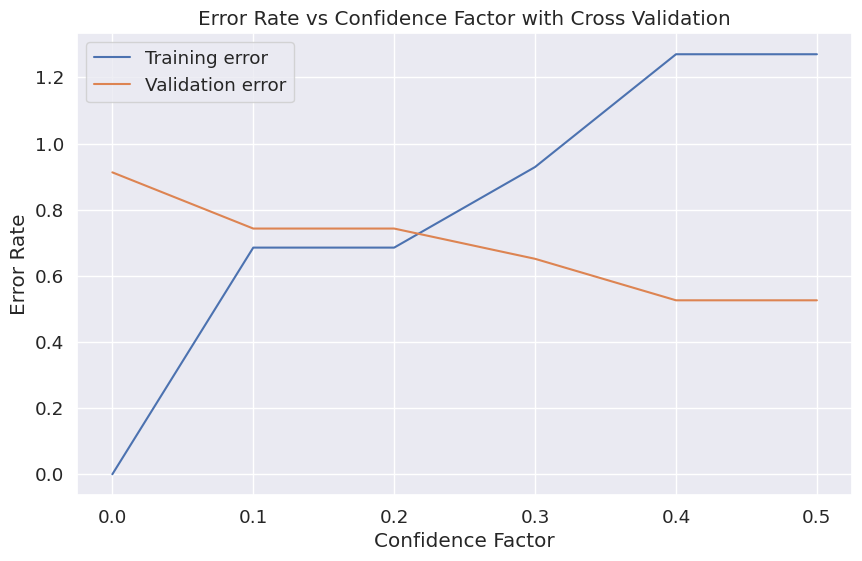

In [ ]:
from sklearn.model_selection import cross_val_score

# Define the confidence factors
confidence_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
train_errors = []
val_errors = []

# Train the model and conduct cross-validation for each confidence factor
for cf in confidence_factors:
    dt = DecisionTreeRegressor(ccp_alpha=cf)
    dt.fit(X_train, y_trainLog)
    y_train_pred = dt.predict(X_train)
    y_val_pred = dt.predict(X_val)
    train_error = mean_squared_error(y_trainLog, y_train_pred)
    val_error = mean_squared_error(y_valLog, y_val_pred)

    # Perform 10-fold cross validation and store mean score
    scores = cross_val_score(dt, X_train, y_trainLog, cv=10)
    val_cv_error = np.mean(scores)

    train_errors.append(train_error)
    val_errors.append(val_cv_error)

# Plot error rate and cross-validation score vs confidence factor
plt.figure(figsize=(10, 6))
plt.plot(confidence_factors, train_errors, label='Training error')
plt.plot(confidence_factors, val_errors, label='Validation error')
plt.xlabel('Confidence Factor')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Error Rate vs Confidence Factor with Cross Validation')
plt.show()


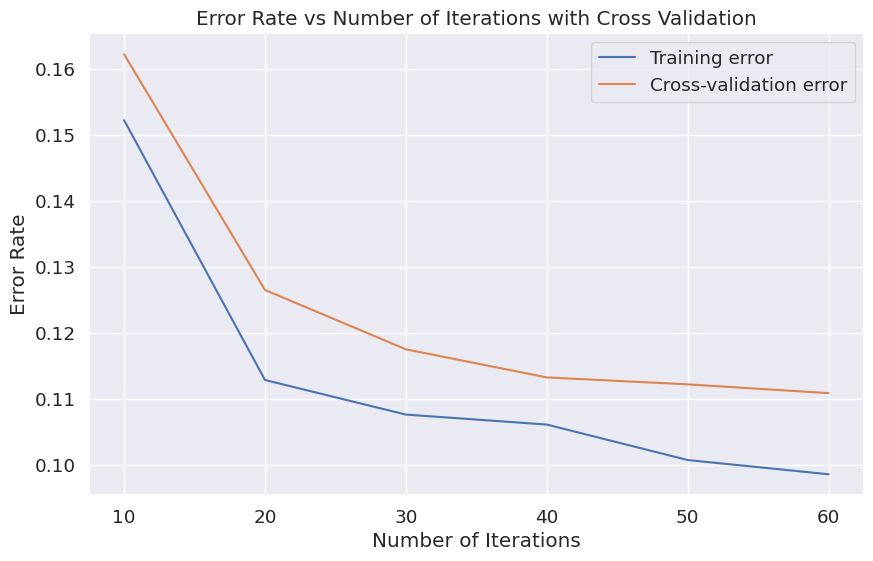

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the numbers of iterations
iterations = [10, 20, 30, 40, 50, 60]
errors = []
cv_errors = []

# Train the model and conduct cross-validation for each number of iterations
for it in iterations:
    xgb = XGBRegressor(n_estimators=it)
    xgb.fit(X_train, y_trainLog)
    y_pred = xgb.predict(X_val)
    error = mean_squared_error(y_valLog, y_pred)
    errors.append(error)
    cv_score = -cross_val_score(xgb, X_train, y_trainLog, cv=10, scoring='neg_mean_squared_error').mean()
    cv_errors.append(cv_score)

# Plot error rate and cross-validation score vs number of iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, errors, label='Training error')
plt.plot(iterations, cv_errors, label='Cross-validation error')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Error Rate vs Number of Iterations with Cross Validation')
plt.show()


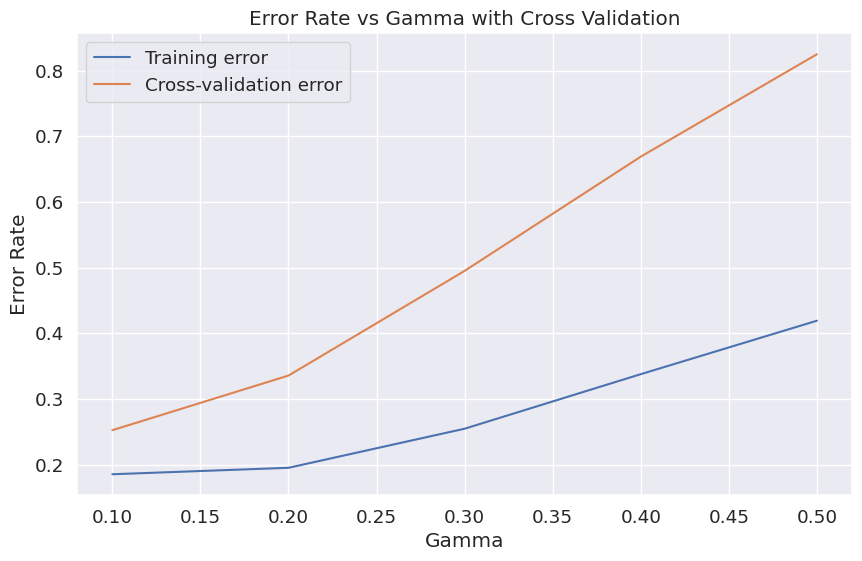

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the gamma values
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
train_errors = []
cv_errors = []

# Train the model and conduct cross-validation for each gamma value
for gamma in gamma_values:
    svr = SVR(kernel='rbf', gamma=gamma)
    svr.fit(X_train, y_trainLog)
    y_train_pred = svr.predict(X_train)
    y_val_pred = svr.predict(X_val)
    train_error = mean_squared_error(y_trainLog, y_train_pred)
    val_error = -cross_val_score(svr, X_train, y_trainLog, cv=10, scoring='neg_mean_squared_error').mean()

    train_errors.append(train_error)
    cv_errors.append(val_error)

# Plot error rate and cross-validation score vs gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, train_errors, label='Training error')
plt.plot(gamma_values, cv_errors, label='Cross-validation error')
plt.xlabel('Gamma')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Error Rate vs Gamma with Cross Validation')
plt.show()


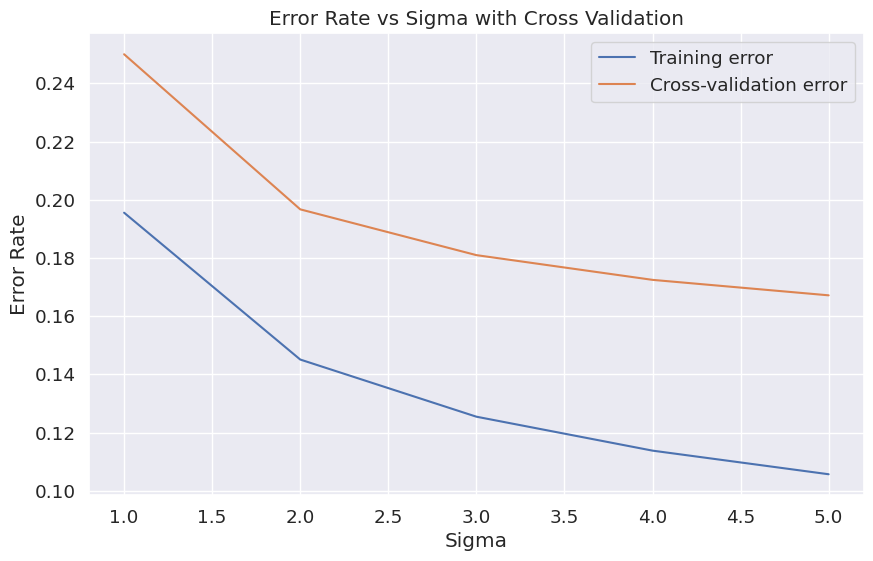

In [ ]:
# Define the sigma values
sigma_values = [1, 2, 3, 4, 5]
train_errors = []
cv_errors = []

# Train the model and conduct cross-validation for each sigma value
for sigma in sigma_values:
    svr = SVR(kernel='rbf', C=sigma)
    svr.fit(X_train, y_trainLog)
    y_train_pred = svr.predict(X_train)
    y_val_pred = svr.predict(X_val)
    train_error = mean_squared_error(y_trainLog, y_train_pred)
    val_error = -cross_val_score(svr, X_train, y_trainLog, cv=10, scoring='neg_mean_squared_error').mean()

    train_errors.append(train_error)
    cv_errors.append(val_error)

# Plot error rate and cross-validation score vs sigma
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, train_errors, label='Training error')
plt.plot(sigma_values, cv_errors, label='Cross-validation error')
plt.xlabel('Sigma')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Error Rate vs Sigma with Cross Validation')
plt.show()


In [ ]:
X_train

,Temperature,Humidity,Visibility,Solar_Radiation,Rainfall,Holiday,Functioning_Day,WorkingDay,Day_Period,Rush_Hour,Hour_Sin,Hour_Cos,DayNumber_Sin,DayNumber_Cos,Month_Sin,Month_Cos,logWind_Speed
387,-1.809482,-0.932279,0.891806,-0.653905,-0.124534,0,1,0,2,0,0.730836,0.682553,-2.449294e-16,1.0,-2.449294e-16,1.000000e+00,1.279947
4362,1.221174,-0.326968,0.891806,-0.423934,-0.124534,0,1,0,1,1,-0.979084,0.203456,-2.449294e-16,1.0,-1.000000e+00,-1.836970e-16,0.171915
4397,0.631880,1.942947,-1.631824,-0.653905,-0.124534,0,1,1,2,0,0.979084,0.203456,8.660254e-01,0.5,-1.000000e+00,-1.836970e-16,-0.371298
4665,0.800250,0.681883,0.891806,0.024509,-0.124534,0,1,0,2,0,0.631088,-0.775711,-8.660254e-01,0.5,-1.000000e+00,-1.836970e-16,-0.371298
2057,-0.546709,-0.427853,-1.324943,0.082002,-0.124534,0,1,1,0,1,-0.997669,-0.068242,-8.660254e-01,-0.5,8.660254e-01,-5.000000e-01,2.010471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.968619,1.236751,-1.472383,-0.653905,-0.124534,0,1,1,2,0,0.887885,0.460065,8.660254e-01,-0.5,-5.000000e-01,-8.660254e-01,-1.055183
5191,-0.378339,0.934096,-0.882622,-0.653905,-0.124534,0,1,1,2,0,0.942261,-0.334880,8.660254e-01,-0.5,-8.660254e-01,5.000000e-01,-1.055183
5226,0.210955,-0.680066,0.891806,-0.584914,-0.124534,0,1,1,1,1,-0.979084,0.203456,1.224647e-16,-1.0,-8.660254e-01,5.000000e-01,0.860262
5390,0.379325,-1.033164,-0.668319,1.346842,-0.124534,0,1,1,0,0,-0.631088,-0.775711,0.000000e+00,1.0,-5.000000e-01,8.660254e-01,-0.371298


Using model: LinearRegression
Train score : 0.8143559240657826
------------------------------
Using model: Ridge
Train score : 0.8143384322240788
------------------------------
Using model: Lasso
Train score : 0.0
------------------------------
Using model: ElasticNet
Train score : 0.021203889946025622
------------------------------
Using model: KNeighborsRegressor
Train score : 0.8635511173657887
------------------------------
Using model: DecisionTreeRegressor
Train score : 1.0
------------------------------
Using model: RandomForestRegressor
Train score : 0.9940380358211213
------------------------------
Using model: BaggingRegressor
Train score : 0.9919451098221576
------------------------------
Using model: AdaBoostRegressor
Train score : 0.7981226689835503
------------------------------
Using model: CatBoostRegressor
Train score : 0.9909145469485042
------------------------------
Using model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

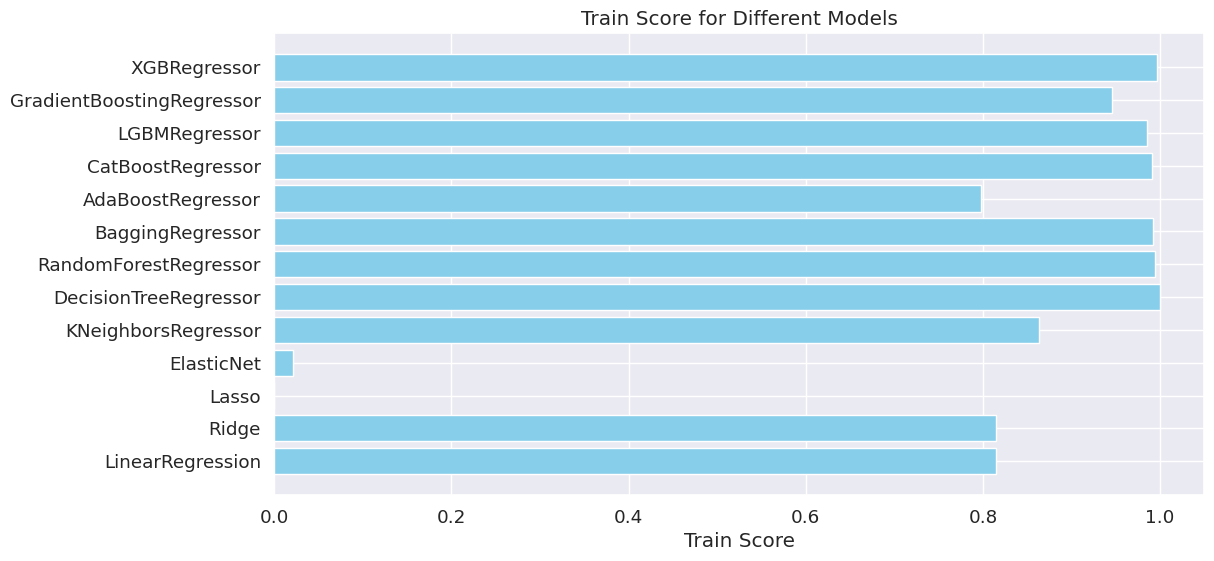

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

models = {
    "LinearRegression":            LinearRegression(),
    "Ridge":                       Ridge(),
    "Lasso":                       Lasso(),
    "ElasticNet":                  ElasticNet(),
    "KNeighborsRegressor":         KNeighborsRegressor(),
    "DecisionTreeRegressor":       DecisionTreeRegressor(),
    "RandomForestRegressor":       RandomForestRegressor(),
    "BaggingRegressor":            BaggingRegressor(),
    "AdaBoostRegressor":           AdaBoostRegressor(),
    "CatBoostRegressor":           CatBoostRegressor(verbose=False),
    "LGBMRegressor":               LGBMRegressor(),
    "GradientBoostingRegressor":   GradientBoostingRegressor(),
    "XGBRegressor":                XGBRegressor()
}

model_names = []
train_scores = []

for name, model in models.items():
    print(f'Using model: {name}')
    model.fit(X_train, y_trainLog)
    train_score = model.score(X_train,y_trainLog)
    model_names.append(name)
    train_scores.append(train_score)
    print(f"Train score : {train_score}")
    print('-'*30)

# Plot train scores for each model
plt.figure(figsize=(12, 6))
plt.barh(model_names, train_scores, color='skyblue')
plt.xlabel('Train Score')
plt.title('Train Score for Different Models')
plt.show()


In [ ]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=[17]
        ),
        keras.layers.Dense(515, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="linear"),
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               4608      
                                                                 
 dense_21 (Dense)            (None, 515)               132355    
                                                                 
 dropout_10 (Dropout)        (None, 515)               0         
                                                                 
 dense_22 (Dense)            (None, 50)                25800     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 162814 (635.99 KB)
Trainable params: 162

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the StratifiedKFold object
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Track the histories
histories = []

# # Loop over each fold
# for X_train, test_index in kf.split(X=, y=y):
#     # Create the train and validation sets
#     X_train=df_nontree.loc[trn_,feature_col_nontree]
#     y_train=df_nontree.loc[trn_,target]

#     X_val=df_nontree.loc[val_,feature_col_nontree]
#     y_val=df_nontree.loc[val_,target]

#     # Create a new model for each fold


# Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error')

# Set up early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.001, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_trainLog, validation_data=(X_val, y_valLog), batch_size=15, epochs=50, callbacks=[early_stopping], verbose=1)

# Save the history
histories.append(history)


Epoch 1/50
308/308 [==============================] - 5s 11ms/step - loss: 3.3605 - val_loss: 0.5430
Epoch 2/50
308/308 [==============================] - 3s 9ms/step - loss: 1.4284 - val_loss: 0.3261
Epoch 3/50
308/308 [==============================] - 3s 10ms/step - loss: 1.3460 - val_loss: 0.4740
Epoch 4/50
308/308 [==============================] - 2s 7ms/step - loss: 1.2242 - val_loss: 0.7552
Epoch 5/50
308/308 [==============================] - 2s 8ms/step - loss: 1.1946 - val_loss: 0.3212
Epoch 6/50
308/308 [==============================] - 2s 7ms/step - loss: 1.0975 - val_loss: 0.3932
Epoch 7/50
308/308 [==============================] - 2s 8ms/step - loss: 1.0606 - val_loss: 0.3051
Epoch 8/50
308/308 [==============================] - 3s 10ms/step - loss: 1.0676 - val_loss: 0.2104
Epoch 9/50
308/308 [==============================] - 3s 10ms/step - loss: 0.9794 - val_loss: 0.1651
Epoch 10/50
308/308 [==============================] - 2s 7ms/step - loss: 0.9326 - val_loss: 0.

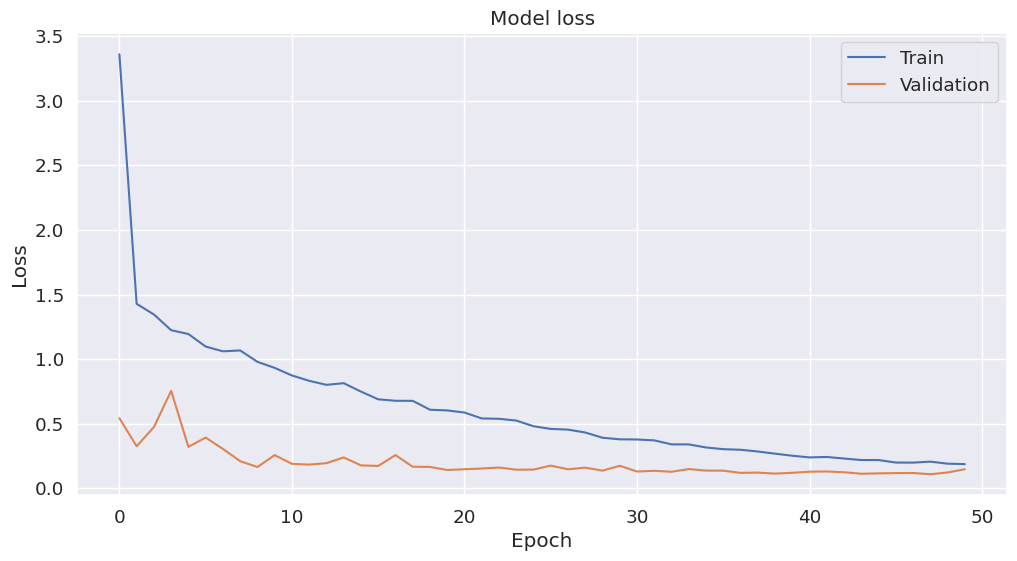

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()




In [ ]:
y_train

387      100
4362    2118
4397     219
4665     934
2057     776
        ... 
3772     266
5191    1213
5226    2499
5390     993
860      332
Name: y, Length: 4608, dtype: int64

##K-Means

In [ ]:
# Define your features and target
features = X_train
target = y_train

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

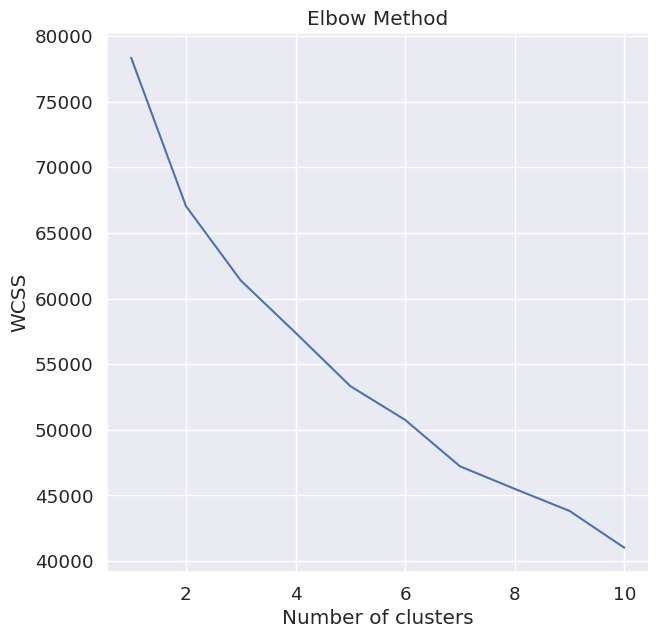

In [ ]:

import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):  # Here, we compute WCSS for k = 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

# Plot the Elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

as we can see we have 2 classes

In [ ]:

# Train K-means on the training data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_features)

# Predict clusters on the training data (not typical, just for demonstration)
train_clusters = kmeans.predict(scaled_features)

silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)
# # Add the predicted clusters as a new column to your datase
# data_with_clusters = pd.DataFrame(np.column_stack([features, train_clusters]), columns=list(features.columns) + ['Predicted_Cluster'])


Silhouette Score: 0.15259776649393098


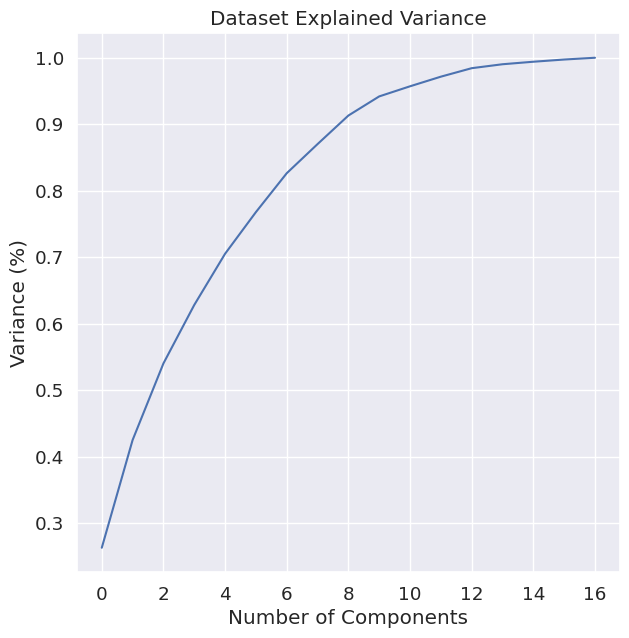

In [ ]:


# Apply PCA
pca = PCA().fit(features)

# Plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Dataset Explained Variance')
plt.show()

90% of the data receved on 8 bins

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=8, random_state=42)
data_pca = pca.fit_transform(scaled_features)

In [ ]:
# Train K-means on the training data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_pca)

# Predict clusters on the training data (not typical, just for demonstration)
train_clusters = kmeans.predict(data_pca)
silhouette_avg = silhouette_score(data_pca, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)
df_kmeans=features.copy()
# Add the predicted clusters as a new column to your datase
data_with_clusters = pd.DataFrame(np.column_stack([df_kmeans, train_clusters]), columns=list(df_kmeans.columns) + ['Predicted_Cluster'])

Silhouette Score: 0.18972221991883417


Text(0, 0.5, 'Principal Component 2')

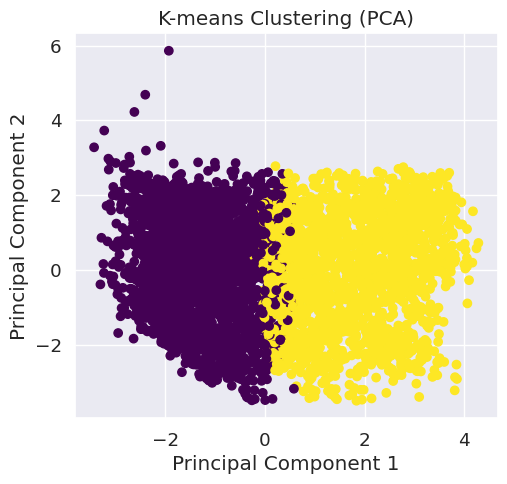

In [ ]:
# Visualize clustered data in 2D
plt.figure(figsize=(12, 5))

# K-means clusters
plt.subplot(121)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


In [ ]:
# Apply ICA for dimensionality reduction
ica = FastICA(n_components=2, random_state=42)
data_ica = ica.fit_transform(scaled_features)


The Silhouette Score is a metric used to measure the quality of clustering in a dataset. It provides insight into the separation distance between clusters and how well-defined they are.

In [ ]:
# Train K-means on the training data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_ica)
silhouette_avg = silhouette_score(data_ica, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)
# Predict clusters on the training data (not typical, just for demonstration)
train_clusters = kmeans.predict(data_ica)

Silhouette Score: 0.370483731951526


 Silhouette Score of 0.37indicates reasonably well-defined clusters, suggesting a moderate degree of separation between clusters. This score indicates that the data points are relatively well-clustered compared to the average distance to points in neighboring clusters.

Text(0, 0.5, 'Independent Component 2')

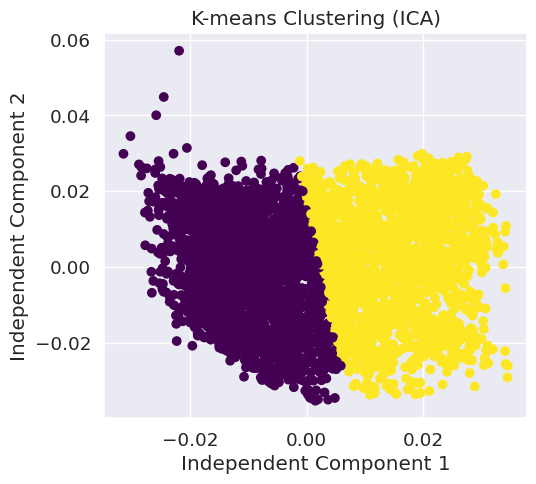

In [ ]:
# Visualize clustered data in 2D
# Visualize clustered data in 2D
plt.figure(figsize=(12, 5))

# K-means clusters
plt.subplot(121)
plt.scatter(data_ica[:, 0], data_ica[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering (ICA)')
plt.xlabel('Independent Component 1')
plt.ylabel('Independent Component 2')

##GMM

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(scaled_features)

In [ ]:

# Train Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data_pca)
silhouette_avg = silhouette_score(data_pca, gmm.predict(data_pca))

print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.4098242410752274


a Silhouette Score of 0.409indicates relatively well-defined clusters with a moderate to high degree of separation between them. This suggests that the clusters are cohesive and the points within each cluster are closer to each other than to points in neighboring clusters.

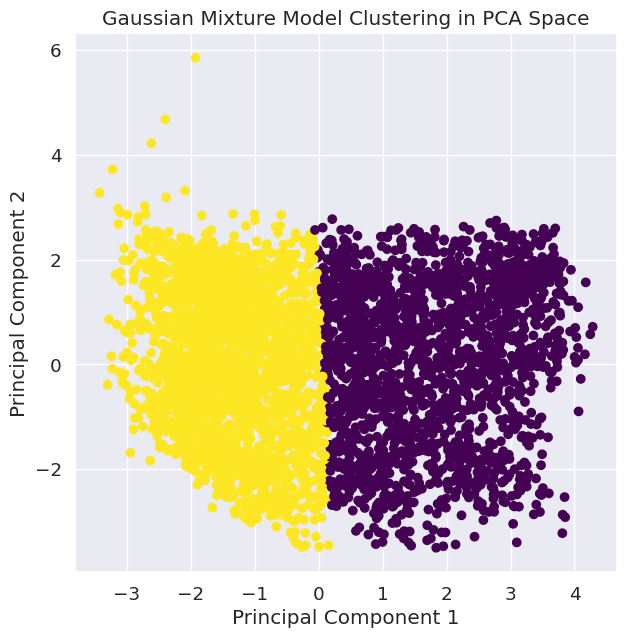

In [ ]:
# Predict clusters on the PCA-reduced data
predicted_clusters = gmm.predict(data_pca)

# Visualize the clusters in 2D (PCA space)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=predicted_clusters, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# Apply ICA for dimensionality reduction
ica = FastICA(n_components=2, random_state=42)
data_ica = ica.fit_transform(scaled_features)


In [ ]:
# Train K-means on the training data
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data_ica)
silhouette_avg = silhouette_score(data_ica, gmm.predict(data_ica))
print("Silhouette Score:", silhouette_avg)

# Predict clusters on the training data (not typical, just for demonstration)
train_clusters = kmeans.predict(data_ica)

Silhouette Score: 0.36643220022747297


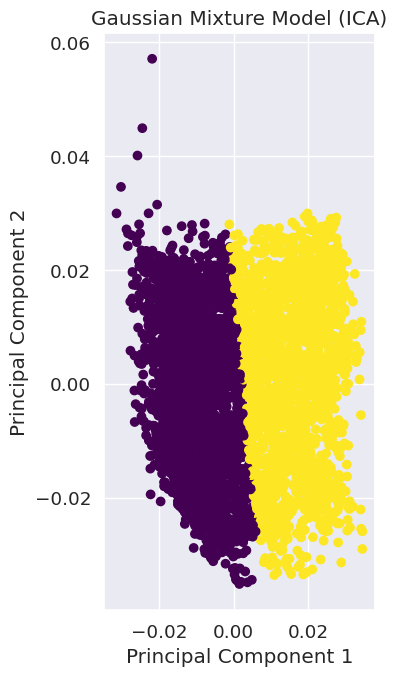

In [ ]:
# GMM clusters
plt.subplot(122)
plt.scatter(data_ica[:, 0], data_ica[:, 1], c=train_clusters, cmap='viridis')
plt.title('Gaussian Mixture Model (ICA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

_____________________________________________________________

________________________________________________________